In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from xhistogram.xarray import histogram
import dask.array as da

from dask.distributed import LocalCluster, Client

cluster = LocalCluster(local_directory='/projekt_agmwend/home_rad/Joshua/dask-worker-space', memory_limit='16GB', n_workers=20, threads_per_worker=1, dashboard_address=':8008')
client = Client(cluster)

basepath = '/projekt_agmwend/data/HALO-AC3/05_VELOX_Tools/ml_sea-ice-classification/predictions/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('.nc')]
files.sort()

import pandas as pd
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

filenames = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')

MODIS = xr.open_dataset('/projekt_agmwend/data/HALO-AC3/06_satellite/MODIS_ice_surface_temperature_MOD29/MOD29_regridded_merged_v3.nc')
VELOX = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MasterArbeit/HALO-AC3_VELOX_coarsen_100_v1s.nc')
BACARDI = xr.concat([xr.open_dataset(file) for file in filenames['BACARDI'].tolist()], dim='time')

VELOX['lat'] = ('time', BACARDI.sel(time=VELOX.time, method='nearest')['lat'].values)
VELOX['lon'] = ('time', BACARDI.sel(time=VELOX.time, method='nearest')['lon'].values)


path = '/projekt_agmwend/home_rad/Joshua/radiometer/'
mira_files = [os.path.join(path, file) for file in os.listdir(path) if 'HALO-AC3' in file]
mira_files.sort()

ds_mira_merged = xr.concat([xr.open_dataset(file) for file in mira_files], dim='time')
ds_mira_merged = ds_mira_merged.sortby('uniRadiometer_freq')

grad_ratio_50_37 = ds_mira_merged.sel(uniRadiometer_freq = 50, method='nearest') - ds_mira_merged.sel(uniRadiometer_freq = 37, method='nearest') / ds_mira_merged.sel(uniRadiometer_freq = 50, method='nearest') + ds_mira_merged.sel(uniRadiometer_freq = 37, method='nearest')

#grad_ratio_50_37.TB.plot.hist(bins=100)  

mira_mask = [1 if ratio > 400 else 0 for ratio in grad_ratio_50_37.TB.values]

ds_mira_merged['mask'] = ('time', mira_mask)    
ds_mira_merged['grad_ratio_50_37'] = ('time', grad_ratio_50_37.TB.values)


In [2]:
pred_2d_at_disk = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1_pred.nc', engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250})
ds_tb = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1.nc', engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250})


mira_subset = ds_mira_merged.sel(time=pred_2d_at_disk.time, method='nearest')


In [3]:
basepath = '/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('0.1_pred.nc')]
files.sort()

pred_2d_all = xr.concat([xr.open_dataset(file, engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250}) for file in files], dim='time')

mira_subset = ds_mira_merged.sel(time=pred_2d_all.time)

pred_2d_all['sic'] = 1 - pred_2d_all.label.where(pred_2d_all.label == 1, other=0).mean(dim=['x', 'y'])


files = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')['BAHAMAS'].tolist()

ds_bahamas = xr.concat([xr.open_dataset(file) for file in files], dim='tid').rename({'tid' : 'time'})
ds_bahamas = ds_bahamas.assign_coords({'TIME' : ds_bahamas.TIME.values}).rename({'TIME' : 'time'})

ds_bahamas = ds_bahamas.sel(time=pred_2d_all.time, method='nearest') 

pred_2d_all['lat'] = ('time', ds_bahamas.IRS_LAT.values)
pred_2d_all['lon'] = ('time', ds_bahamas.IRS_LON.values)

pred_2d_all[list(ds_bahamas.keys())] = ds_bahamas[list(ds_bahamas.keys())]

fram_strait = pred_2d_all.where((pred_2d_all.lat < 81) & (pred_2d_all.lon > -10) )

In [4]:
pred_2d_all

<xarray.Dataset>
Dimensions:    (time: 48792, x: 635, y: 507)
Coordinates:
  * time       (time) datetime64[ns] 2022-03-16T15:55:00 ... 2022-04-08T09:43:38
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 627 628 629 630 631 632 633 634
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 499 500 501 502 503 504 505 506
Data variables: (12/50)
    label      (time, x, y) int64 dask.array<chunksize=(250, 250, 250), meta=np.ndarray>
    T_skin     (time, x, y) float32 dask.array<chunksize=(250, 250, 250), meta=np.ndarray>
    sic        (time) float64 dask.array<chunksize=(250,), meta=np.ndarray>
    lat        (time) float64 82.12 82.12 82.12 82.12 ... 79.13 79.12 79.12
    lon        (time) float64 4.075 4.081 4.087 4.094 ... -5.453 -5.445 -5.436
    IGI_RMSX   (time) float32 0.216 0.2159 0.2159 0.2161 ... 0.2048 0.205 0.2052
    ...         ...
    TS         (time) float32 222.7 222.8 222.8 222.9 ... 231.5 231.4 231.3
    RELHUM     (time) float32 1.156 1.143 1.142 1.135 ... 0.6285 0.6343 0.6433
    SOURCE     (time) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    WS         (time) float32 35.24 35.24 35.06 34.96 ... 14.11 14.24 14.27
    MIXRATIOV  (time) float32 3.952 3.952 3.952 3.952 ... 4.413 4.413 4.428
    MIXRATIO   (time) float32 0.002458 0.002458 0.002458 ... 0.002745 0.002754
Attributes: (12/23)
    Conventions:             "CF-1.8"
    author:                  Michael Schäfer, Sophie Rosenburg, André Ehrlich...
    campaign:                HALO-AC3
    comment_1:               Band wavelength range: 7.70 - 12.00 micrometers
    comment_2:               Flight direction is towards positive y-direction...
    comment_3:               Thermal infrared imager information: focal lengt...
    ...                      ...
    source:                  Airborne imaging with the VELOX system
    title:                   Two-dimensional cloud-top or surface brightness ...
    variable:                BT_2D, BT_Center
    version:                 Version v3.0 from 2023-09-11
    label:                   1: Open Water, 2: Thin Ice, 3: Snow-covered Sea Ice
    T_skin:                  Skin temperature in °C

In [5]:
from haversine import haversine, Unit
from sklearn.neighbors import BallTree, KDTree


lat_slice = slice(77, 81)
lon_slice = slice(-5, 10)

condition = (pred_2d_all.lat > lat_slice.start) & (pred_2d_all.lat < lat_slice.stop) & (pred_2d_all.lon > lon_slice.start) & (pred_2d_all.lon < lon_slice.stop)

fram_strait = pred_2d_all.where(condition, drop=True)

ds_strong = fram_strait.sel(time='2022-04-01').sortby('time')
ds_weak = fram_strait.sel(time='2022-04-04').sortby('time')

ds_strong['rad_lat'] = np.deg2rad(ds_strong.lat)
ds_strong['rad_lon'] = np.deg2rad(ds_strong.lon)

ds_weak['rad_lat'] = np.deg2rad(ds_weak.lat)
ds_weak['rad_lon'] = np.deg2rad(ds_weak.lon)

ds_weak.lat.shape, ds_strong.lat.shape

### match lon and lat for both cases; find the closest point in the other dataset

from scipy.spatial import cKDTree

ball = BallTree(np.column_stack((ds_strong.rad_lat.values, ds_strong.rad_lon.values)), metric='haversine')

distances, indices = ball.query(np.column_stack((ds_weak.rad_lat.values, ds_weak.rad_lon.values)))

km_distances = distances * 6371

print(km_distances.shape)

### filter out points that are too far away
print(np.mean(km_distances))

print(indices)


indices = indices[km_distances < 10]

unique, counts = np.unique(indices, return_counts=True)

unique_times = ds_strong.time.isel(time=unique)


ds_strong_matched = ds_strong.isel(time=indices)

# plt.figure(figsize=(10, 10))
# plt.scatter(ds_strong_matched.lon, ds_strong_matched.lat, c='r', label='strong', alpha=1, marker='o' ,s=16)

# plt.scatter(ds_weak.lon, ds_weak.lat, c='b', label='weak', alpha=1, s=4)

(3113, 1)
1.2361939299449503
[[   0]
 [   0]
 [   0]
 ...
 [6241]
 [6242]
 [6243]]


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


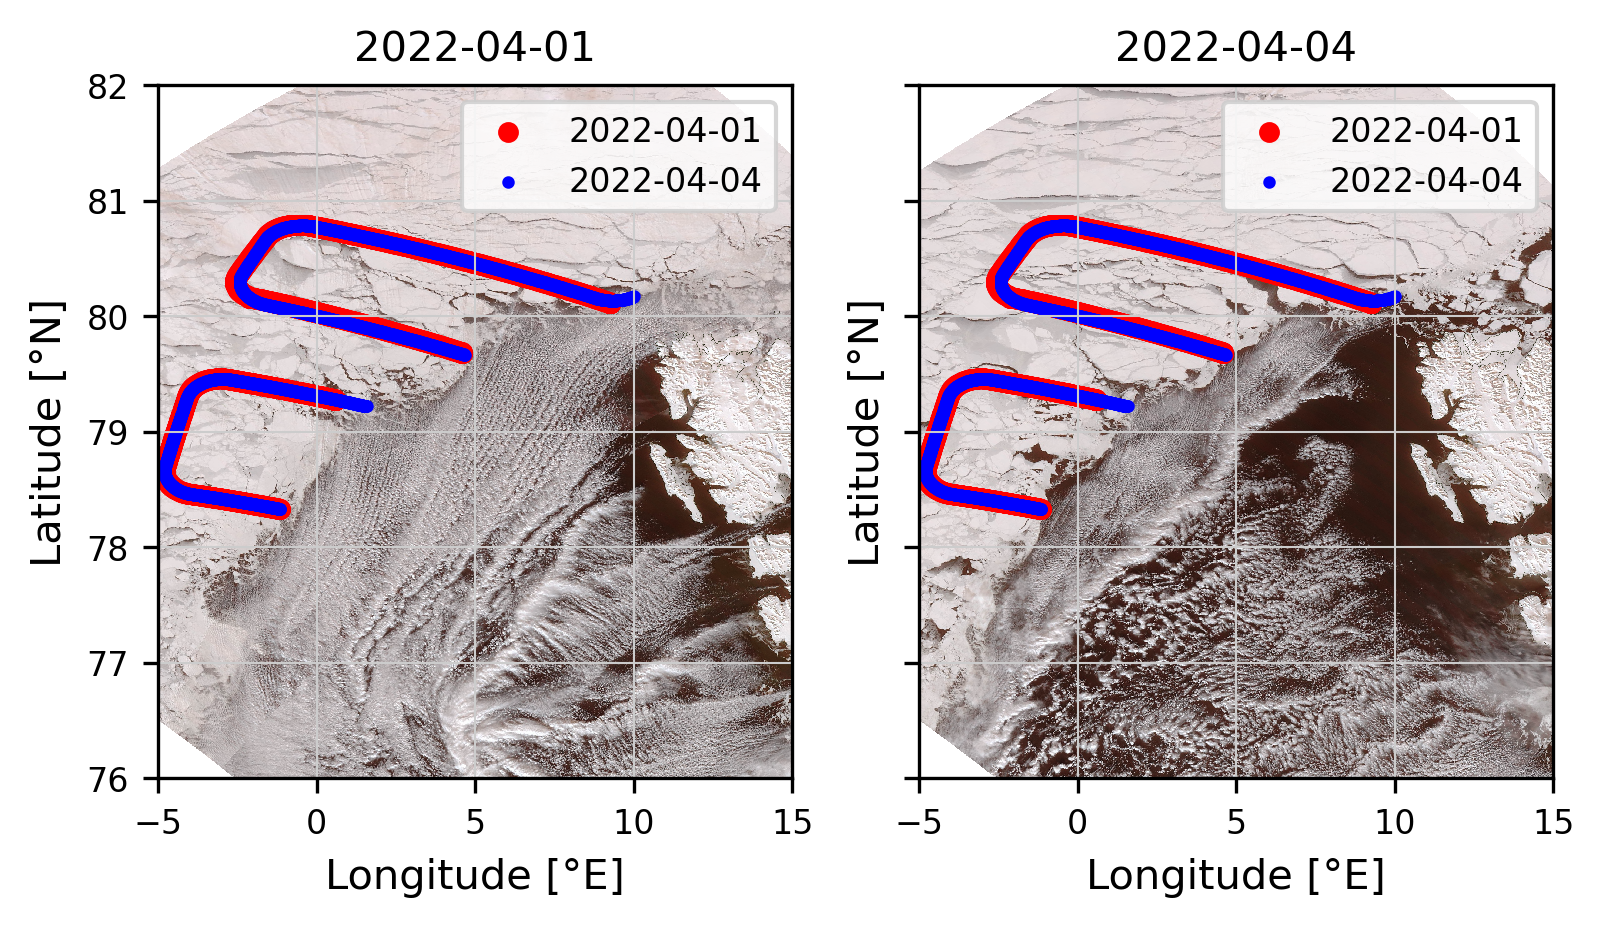

In [6]:
ds1 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/satellite/snapshot-2022-04-01T00_00_00Z.tif', engine='rasterio')
ds2 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/satellite/snapshot-2022-04-04T00_00_00Z.tif', engine='rasterio')

ds_reprojected = ds2.rio.reproject('EPSG:4326', resolution=0.005)
ds_reprojected_2 = ds_reprojected.where(ds_reprojected < 256) / 256


ds_reprojected = ds1.rio.reproject('EPSG:4326', resolution=0.005)
ds_reprojected_1 = ds_reprojected.where(ds_reprojected < 256) / 256


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ds_reprojected_1.isel(band=[2,1,0]).band_data.plot.imshow(cmap='viridis', vmin=0, vmax=1, ax=ax1)
ds_reprojected_2.isel(band=[2,1,0]).band_data.plot.imshow(cmap='viridis', vmin=0, vmax=1, ax=ax2)

title = ['2022-04-01', '2022-04-04']

for ax in (ax1, ax2):

    ax.set_xlim(-5, 15)
    ax.set_ylim(76, 82)
    ax.scatter(ds_strong_matched.lon, ds_strong_matched.lat, c='r', label='2022-04-01', alpha=1, marker='o' ,s=16)
    ax.scatter(ds_weak.lon, ds_weak.lat, c='b', label='2022-04-04', alpha=1, s=4)

    ax.set_title(title.pop(0))
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')

    ax.legend(loc='upper right', fontsize=8)

plt.savefig('../../plots/weak_strong_satellite.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, '2022-04-04')

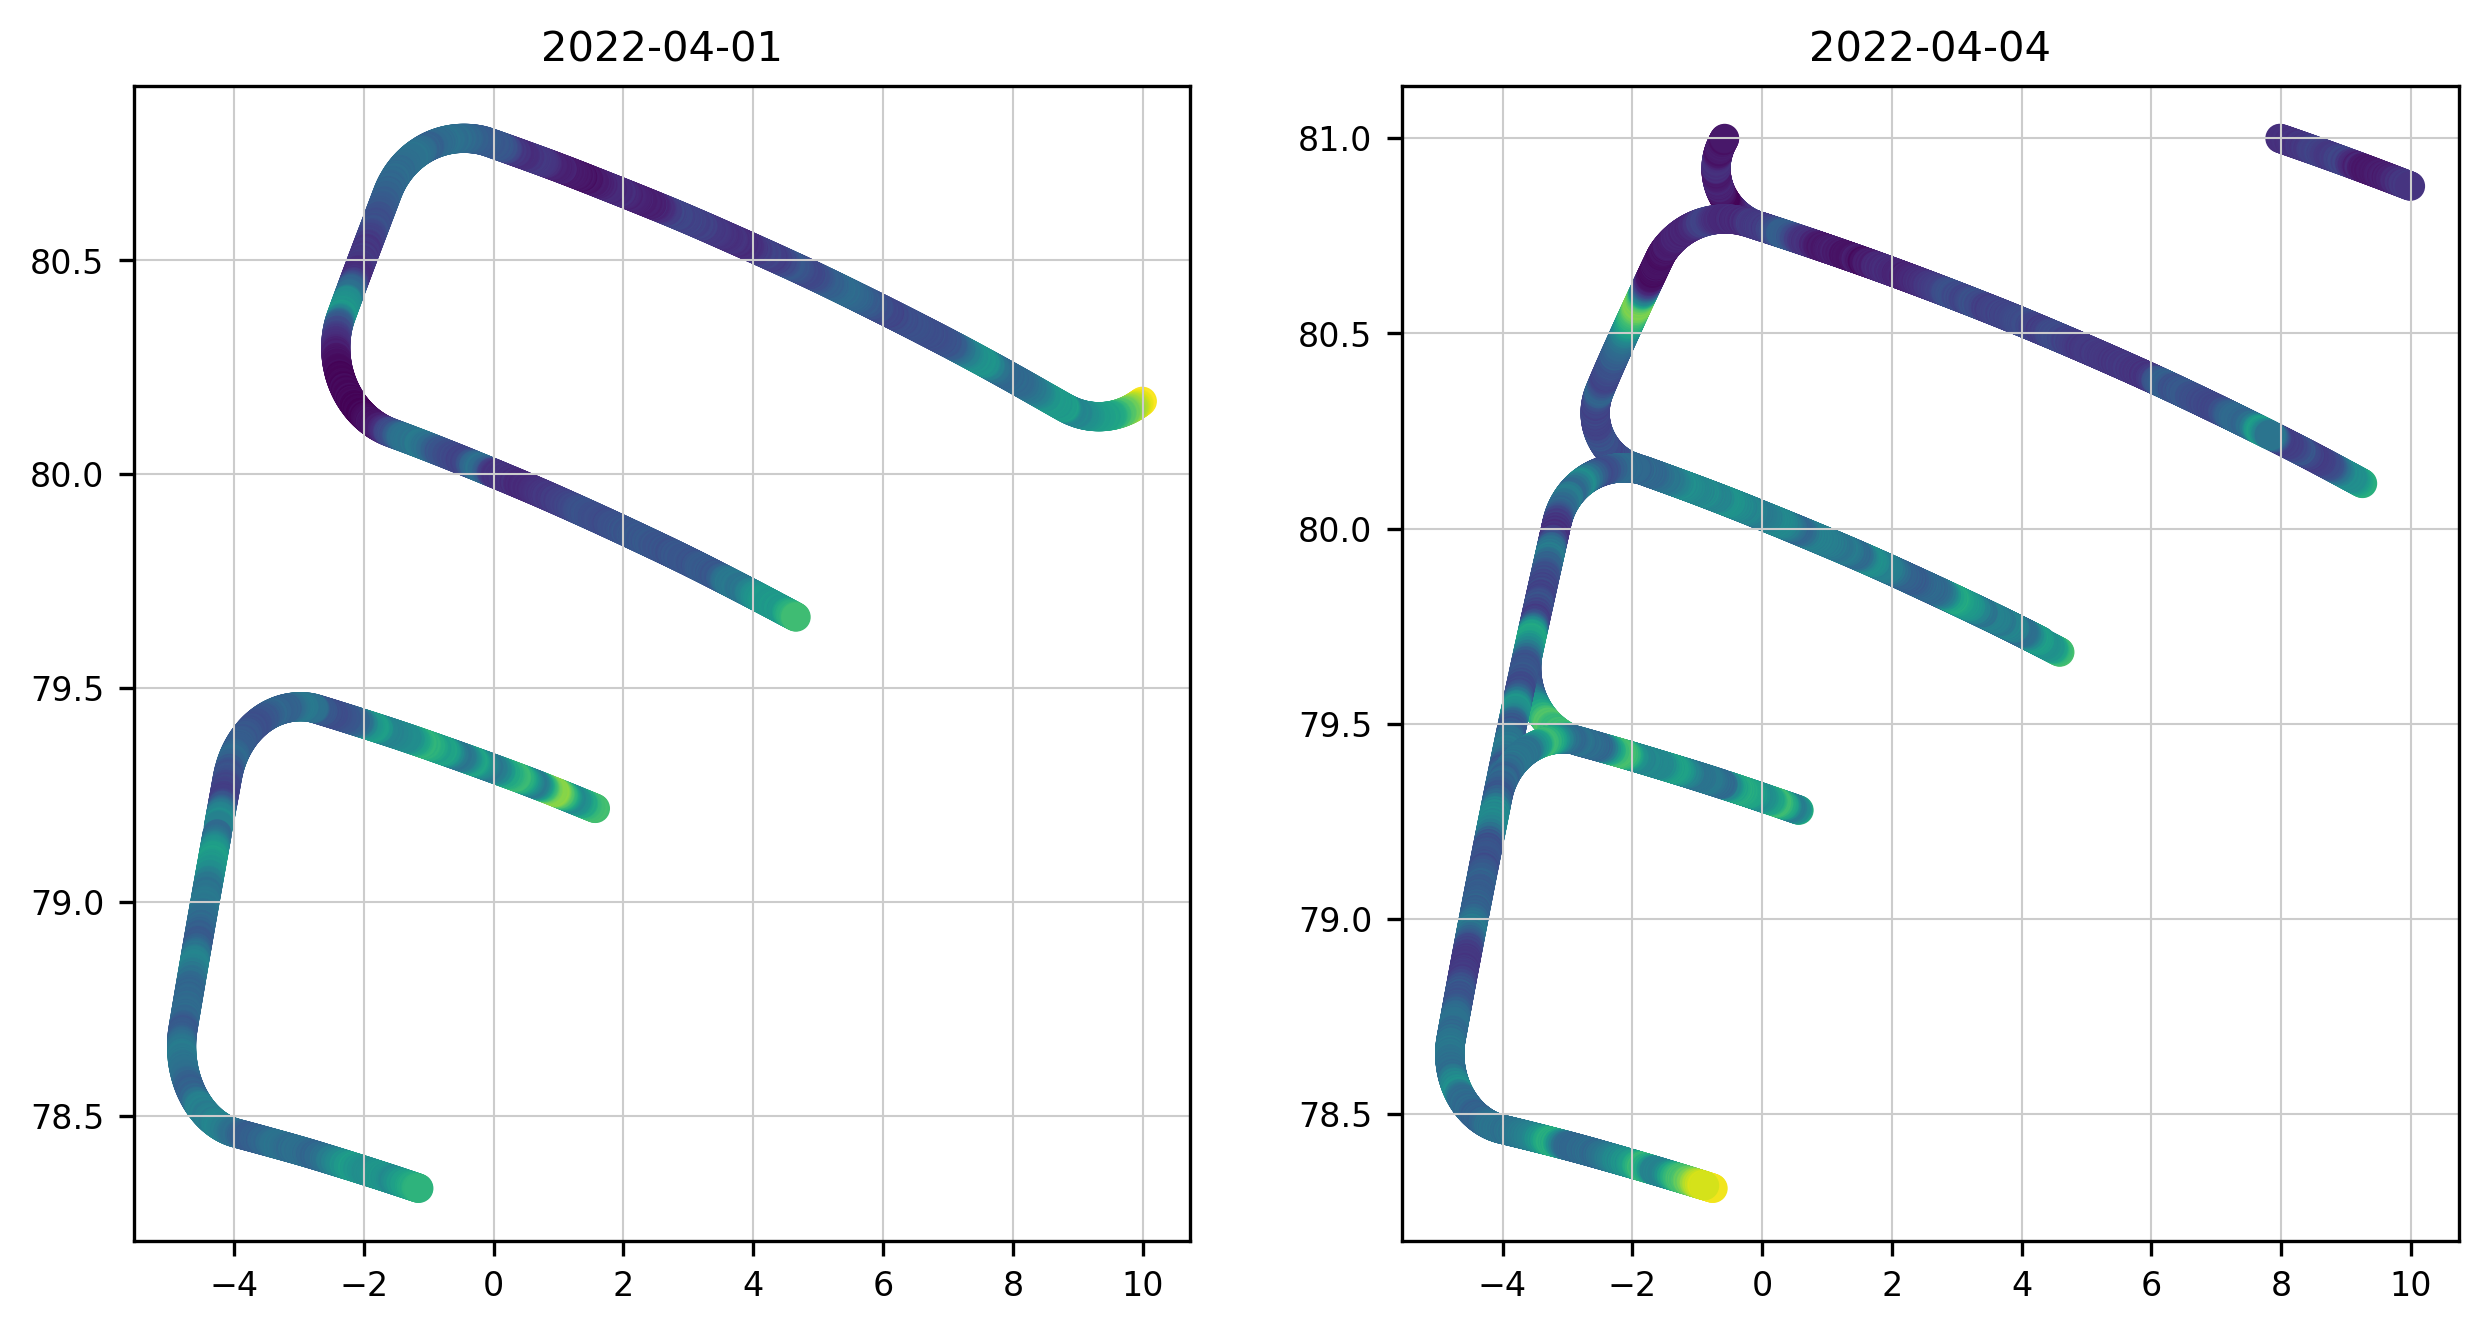

In [7]:
### plot them on a map first... 

ds_strong = fram_strait.sel(time='2022-04-01')
ds_weak = fram_strait.sel(time='2022-04-04')


x = ds_weak.lon.values
y = ds_weak.lat.values
z = ds_weak.T_skin.mean(dim=['x', 'y']).values

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x, y, c=z, cmap='viridis')
ax[0].set_title('2022-04-01')

x = ds_strong.lon.values
y = ds_strong.lat.values
z = ds_strong.T_skin.mean(dim=['x', 'y']).values

ax[1].scatter(x, y, c=z, cmap='viridis')
ax[1].set_title('2022-04-04')

In [8]:
MODIS = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MODIS/MODIS_Aqua_Sea_Ice_Extent_and_IST_Daily_L3_Global_4km_EASE-Grid_Day_V061.nc')

MODIS_1 = MODIS.sel(time='2022-04-01')
MODIS_2 = MODIS.sel(time='2022-04-04')

lons = ds_weak.lon.values
lats = ds_weak.lat.values

result_ds = xr.Dataset(
    data_vars=dict(
        MODIS_skin_T_weak =(['time'], np.zeros(len(lons)) * np.nan),
        MODIS_skin_T_strong =(['time'], np.zeros(len(lons)) * np.nan),
        distances=(['time'], np.zeros(len(lons))),
    ),
    coords=dict(
        time=ds_weak.time.values,
    )
)



for subset, vel_sel in zip([MODIS_1, MODIS_2], [ds_strong_matched, ds_weak]):

    lons = vel_sel.lon.values
    lats = vel_sel.lat.values
    fmt_time = subset.time.dt.strftime('%Y-%m-%d').values.item()

    for i, (lon, lat) in tqdm(enumerate(zip(lons, lats))):
        

        closest_lat = float(subset.lat.sel(lat=lat, method='nearest').values)
        closest_lon = float(subset.lon.sel(lon=lon, method='nearest').values)
        lon = lon.astype(float)
        lat = lat.astype(float)

        distance = haversine((lat, lon), (closest_lat, closest_lon), unit=Unit.KILOMETERS)
        mod_sst = subset.sel(lat=closest_lat, lon=closest_lon).IST.values.item()

        if (distance < 5) & ~np.isnan(mod_sst):

            if fmt_time == '2022-04-01':
                result_ds['MODIS_skin_T_strong'][i] = mod_sst - 273.15
            if fmt_time == '2022-04-04':

                result_ds['MODIS_skin_T_weak'][i] = mod_sst - 273.15


0it [00:00, ?it/s]

3039it [00:04, 668.12it/s]
3113it [00:04, 775.09it/s]


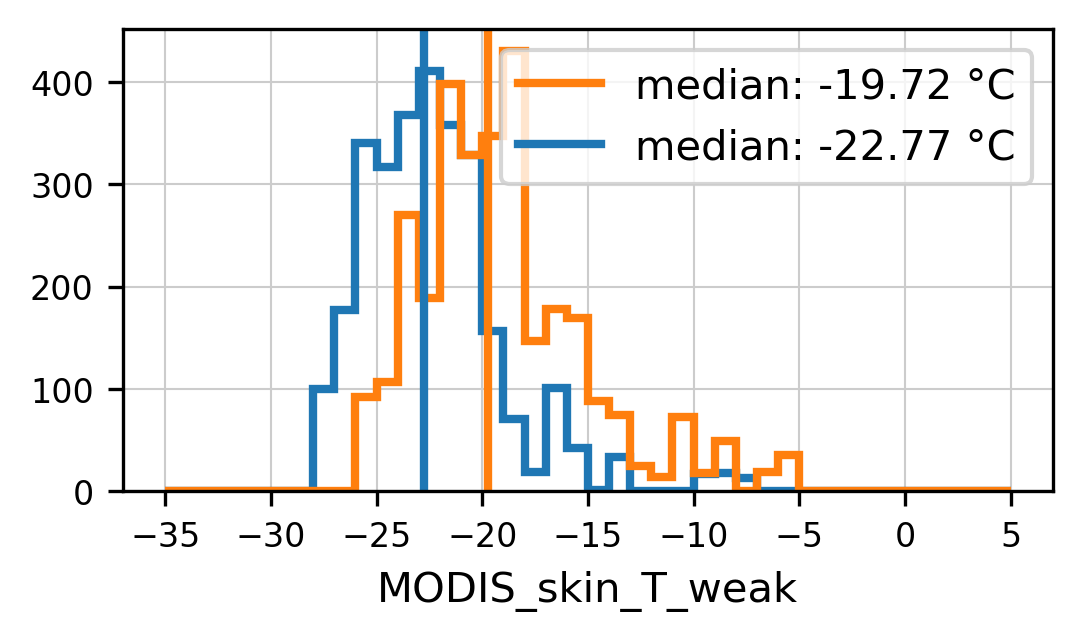

In [14]:
fig, ax = plt.subplots(figsize=(4, 2))


bins = np.linspace(-35, 5, 41)
result_ds['MODIS_skin_T_strong'].plot.hist(bins=bins,  histtype='step', ls='-', lw=2)
result_ds['MODIS_skin_T_weak'].plot.hist(bins=bins, histtype='step', ls='-', lw=2)

MODIS_weak_median = result_ds['MODIS_skin_T_weak'].median().values
MODIS_strong_median = result_ds['MODIS_skin_T_strong'].median().values

ax.axvline(MODIS_weak_median, color='C1', label=f'median: {MODIS_weak_median:.2f} °C', ls='-')
ax.axvline(MODIS_strong_median, color='C0', label=f'median: {MODIS_strong_median:.2f} °C', ls='-')

plt.legend()


 

weak: 978712800, strong: 957464430


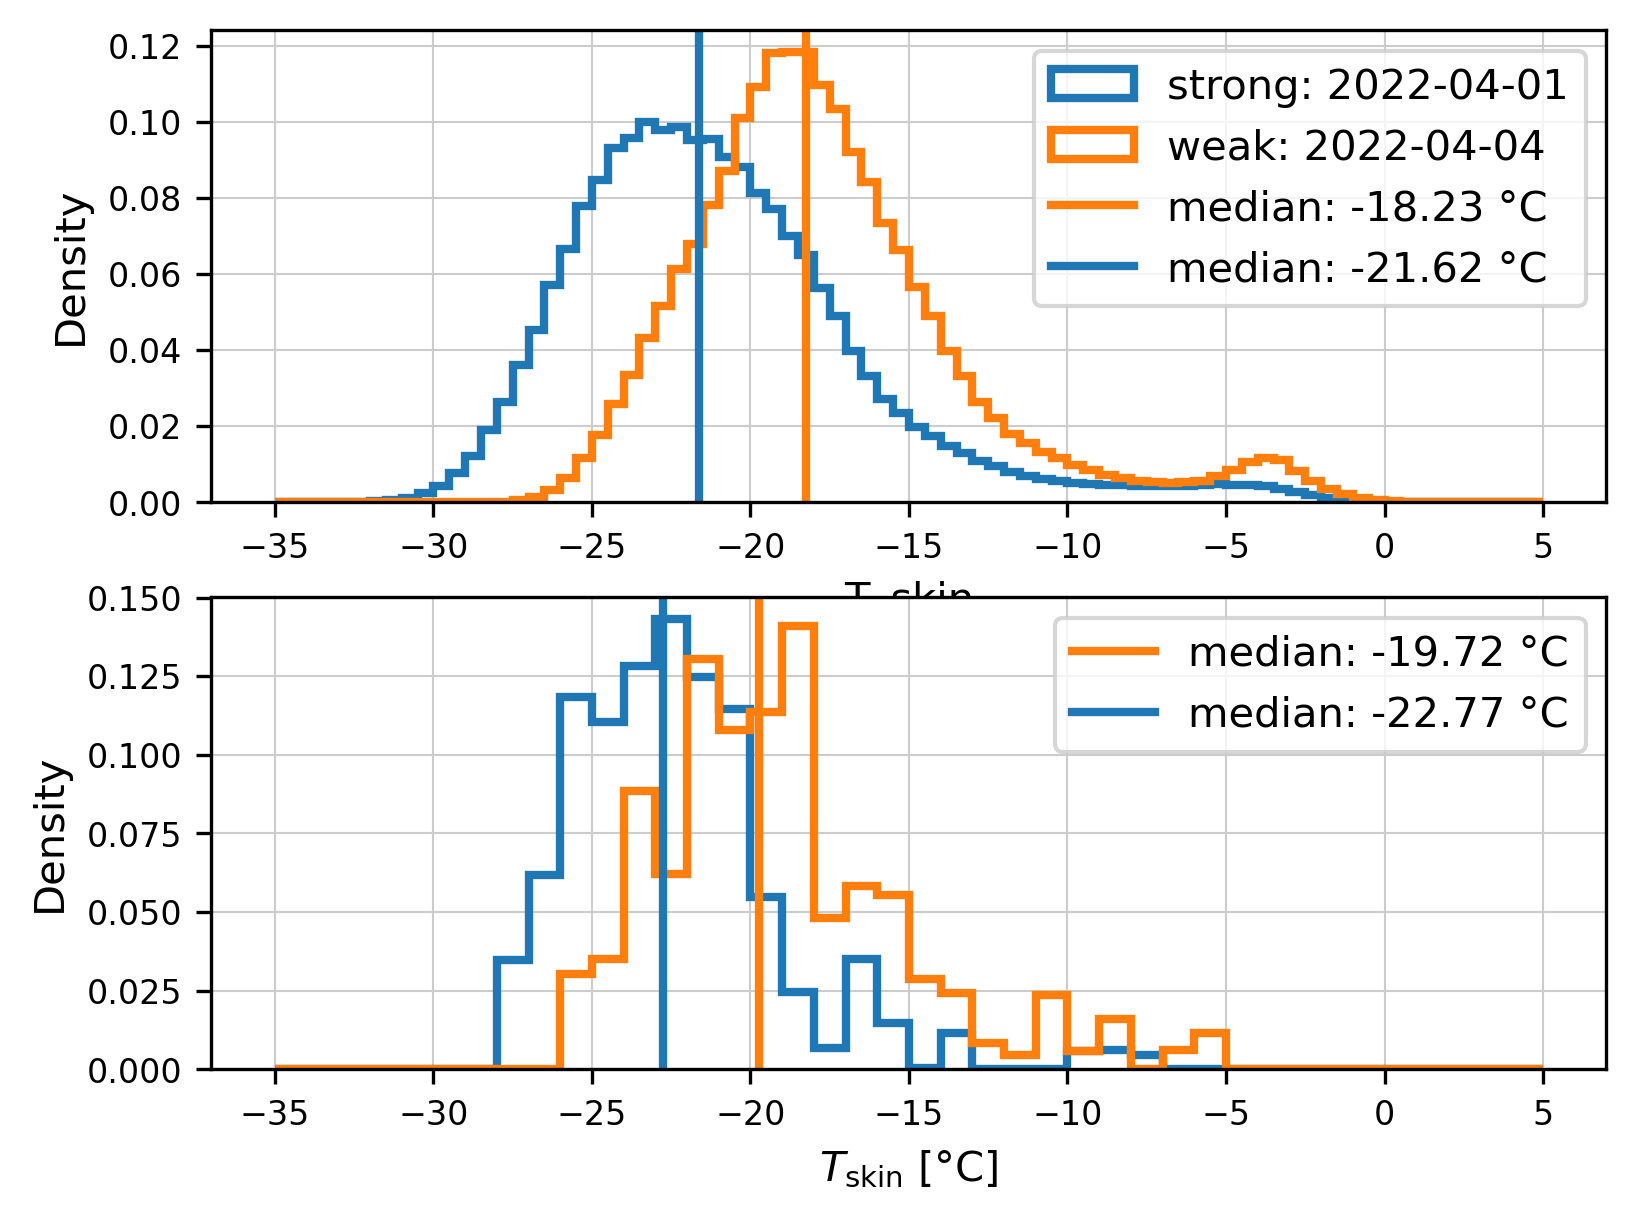

In [ ]:
fig, (ax, ax2) = plt.subplots(2, figsize=(6, 4.5))

bins = np.linspace(-35, 5, 81)

ds_strong_matched['T_skin'].plot.hist(bins=bins, label='strong: 2022-04-01', histtype='step', ax=ax, lw=2, color='C0', density=1)
ds_weak['T_skin'].plot.hist(bins=bins, label='weak: 2022-04-04', histtype='step', ax=ax, lw=2, color='C1', density=1)


median_weak = np.nanmedian(ds_weak['T_skin'].values)
median_strong = np.nanmedian(ds_strong_matched['T_skin'].values)

ax.axvline(median_weak, color='C1', label=f'median: {median_weak:.2f} °C')
ax.axvline(median_strong, color='C0', label=f'median: {median_strong:.2f} °C')


ax.legend(loc='upper right')

total_counts_weak = ds_weak['T_skin'].count().values

total_counts_strong = ds_strong_matched['T_skin'].count().values

bins = np.linspace(-35, 5, 41)


print(f'weak: {total_counts_weak}, strong: {total_counts_strong}')

result_ds['MODIS_skin_T_strong'].plot.hist(bins=bins,  histtype='step', lw=2, density=1, ax=ax2)
result_ds['MODIS_skin_T_weak'].plot.hist(bins=bins, histtype='step', lw=2, density=1, ax=ax2)

MODIS_weak_median = result_ds['MODIS_skin_T_weak'].median().values
MODIS_strong_median = result_ds['MODIS_skin_T_strong'].median().values

ax2.axvline(MODIS_weak_median, color='C1', label=f'median: {MODIS_weak_median:.2f} °C')
ax2.axvline(MODIS_strong_median, color='C0', label=f'median: {MODIS_strong_median:.2f} °C')

ax2.set_xlabel(r'$T_\mathrm{skin}$ [°C]')

ax.set_ylabel('Density')
ax2.set_ylabel('Density')


ax2.legend(loc='upper right')
plt.savefig('../../plots/weak_strong_hist.png', dpi=300, bbox_inches='tight')

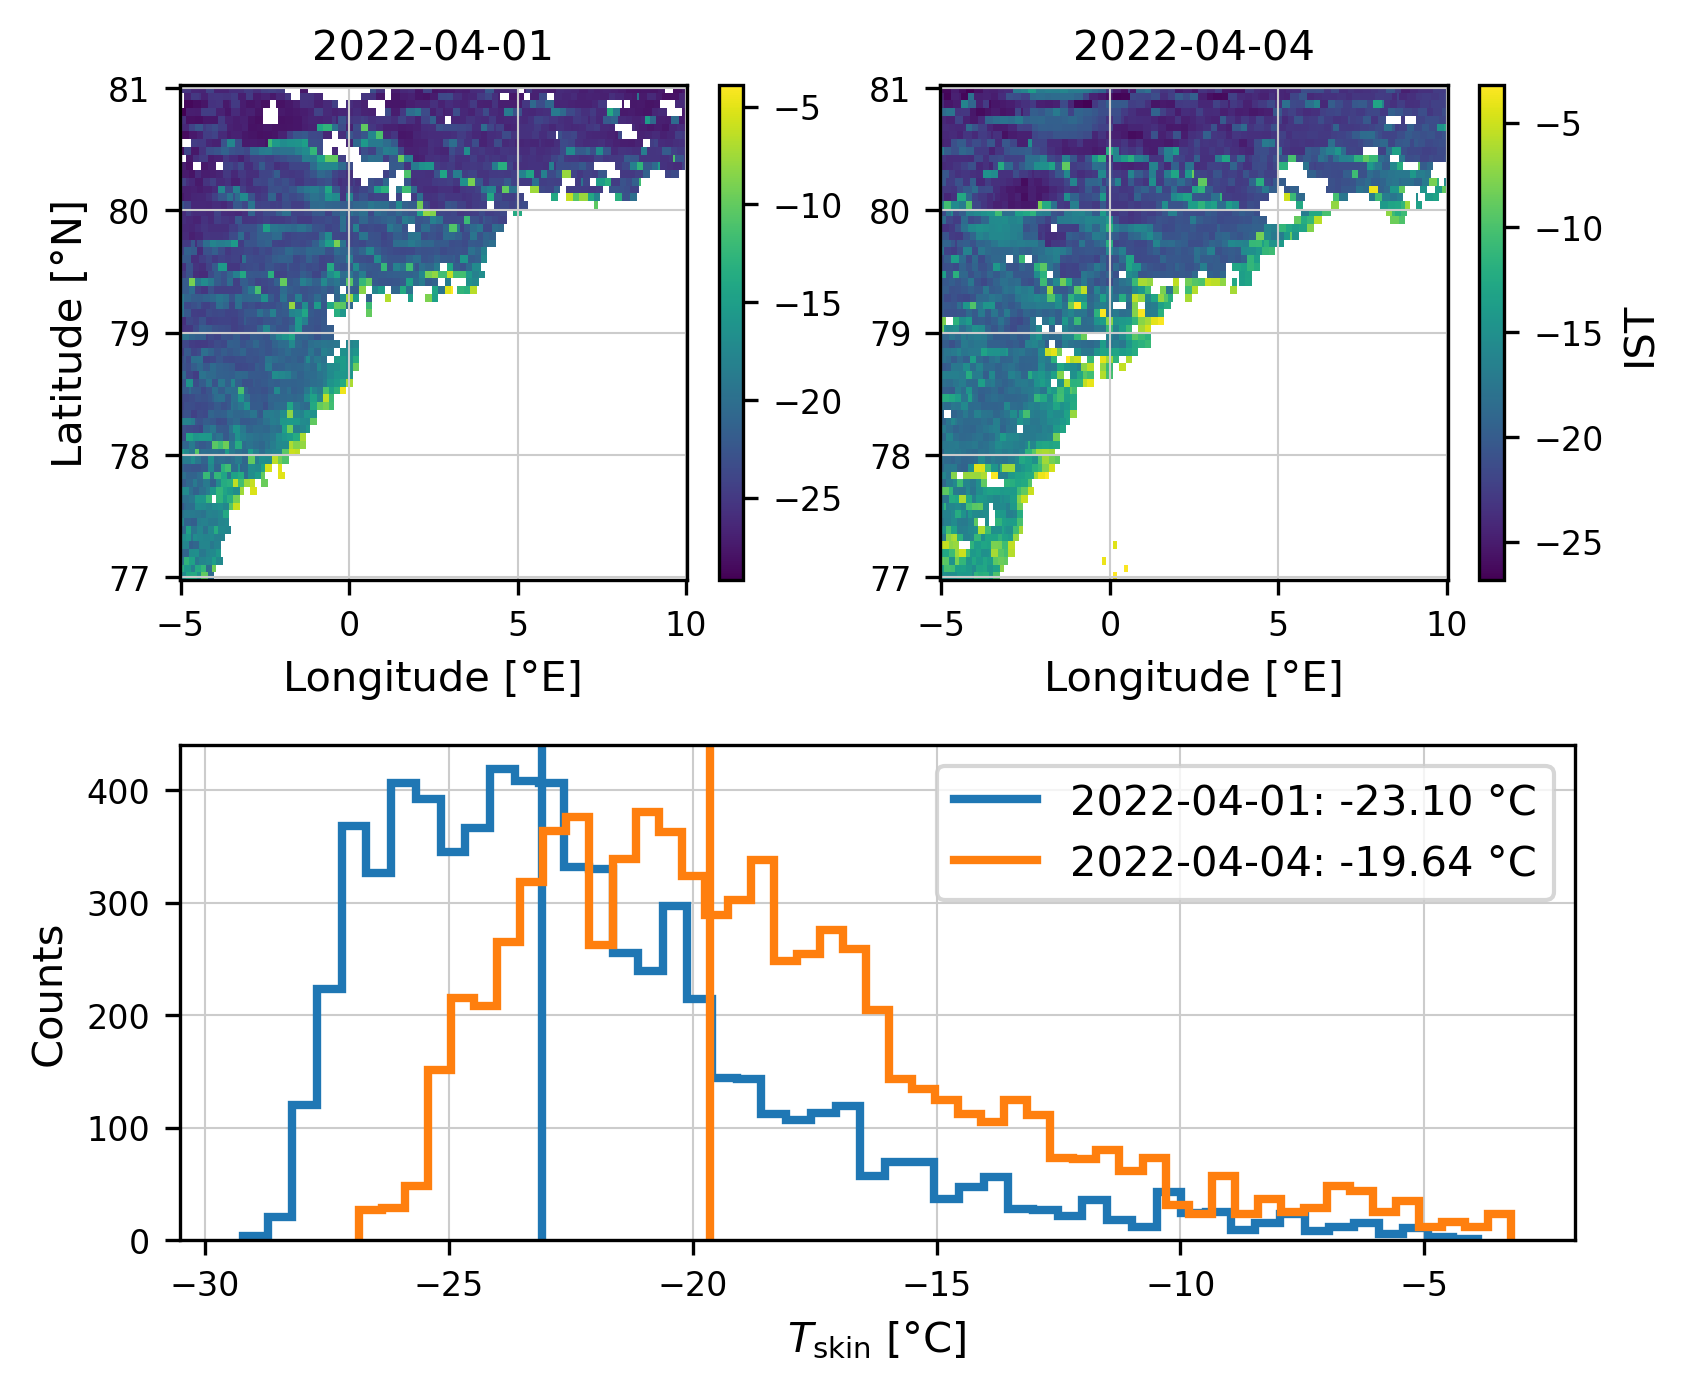

In [ ]:
MODIS = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MODIS/MODIS_Aqua_Sea_Ice_Extent_and_IST_Daily_L3_Global_4km_EASE-Grid_Day_V061.nc')



lat_slice = slice(81, 77)
lon_slice = slice(-5, 10)

fig, ax = plt.subplot_mosaic(
    """
    AABB
    AABB
    CCCC
    CCCC
    """,
    figsize=(6, 5), 
    gridspec_kw={'hspace' : 1, 'wspace' : 0.5}
)

MODIS = MODIS.where(MODIS.IST < 270)
MODIS['IST'] = MODIS.IST - 273.15

MODIS.sel(time='2022-04-01').sel(lat=lat_slice, lon=lon_slice).IST.plot.imshow(ax=ax['A'],  cbar_kwargs={'label' : ''})
MODIS.sel(time='2022-04-04').sel(lat=lat_slice, lon=lon_slice).IST.plot.imshow(ax=ax['B'])

MODIS.sel(time='2022-04-01').sel(lat=lat_slice, lon=lon_slice).IST.plot.hist(bins=50, ax=ax['C'], histtype='step', lw=2)
median = MODIS.sel(time='2022-04-01').sel(lat=lat_slice, lon=lon_slice).IST.median().values
ax['C'].axvline(median, color='C0', label=f'2022-04-01: {median:.2f} °C')

MODIS.sel(time='2022-04-04').sel(lat=lat_slice, lon=lon_slice).IST.plot.hist(bins=50, ax=ax['C'], histtype='step', lw=2)
median = MODIS.sel(time='2022-04-04').sel(lat=lat_slice, lon=lon_slice).IST.median().values
ax['C'].axvline(median, color='C1', label=f'2022-04-04: {median:.2f} °C')

ax['C'].legend(loc='upper right')


ax['A'].set_title('2022-04-01')
ax['B'].set_title('2022-04-04')

ax['A'].set_xlabel('Longitude [°E]')
ax['A'].set_ylabel('Latitude [°N]')
ax['B'].set_xlabel('Longitude [°E]')
ax['B'].set_ylabel('')

ax['C'].set_xlabel(r'$T_\mathrm{skin}$ [°C]')
ax['C'].set_ylabel('Counts')
ax['C'].set_title('')

plt.savefig('../../plots/MODIS_map_and_hist.png', dpi=300, bbox_inches='tight')

In [79]:
bins = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
most_occuring_label_weak = histogram(ds_weak['label'], bins=bins, dim=['x', 'y']).sum(dim='time') / ds_weak['label'].size
most_occuring_label_strong = histogram(ds_strong_matched['label'], bins=bins, dim=['x', 'y']).sum(dim='time') / ds_strong_matched['label'].size
most_occuring_label_weak.persist()
most_occuring_label_strong.persist()

<xarray.DataArray 'histogram_label' (label_bin: 4)>
dask.array<truediv, shape=(4,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
  * label_bin  (label_bin) float64 1.0 2.0 3.0 4.0

In [80]:

#most_occuring_label_weak.sel(label_bin=[1, 2, 4]).plot(ax=ax, label='weak: 2022-04-04', lw=0, marker='o', markersize=3)
#most_occuring_label_strong.sel(label_bin=[1, 2, 4]).plot(ax=ax, label='strong: 2022-04-01', lw=0, marker='o', markersize=3)
#ax.set_xticks([1, 2, 4])
#ax.set_xticklabels(['open water', 'thin ice', 'snow-covered ice'])

open_water_weak = most_occuring_label_weak.sel(label_bin=1).values
thin_ice_weak = most_occuring_label_weak.sel(label_bin=2).values
snow_covered_ice_weak = most_occuring_label_weak.sel(label_bin=4).values

open_water_strong = most_occuring_label_strong.sel(label_bin=1).values
thin_ice_strong = most_occuring_label_strong.sel(label_bin=2).values
snow_covered_ice_strong = most_occuring_label_strong.sel(label_bin=4).values



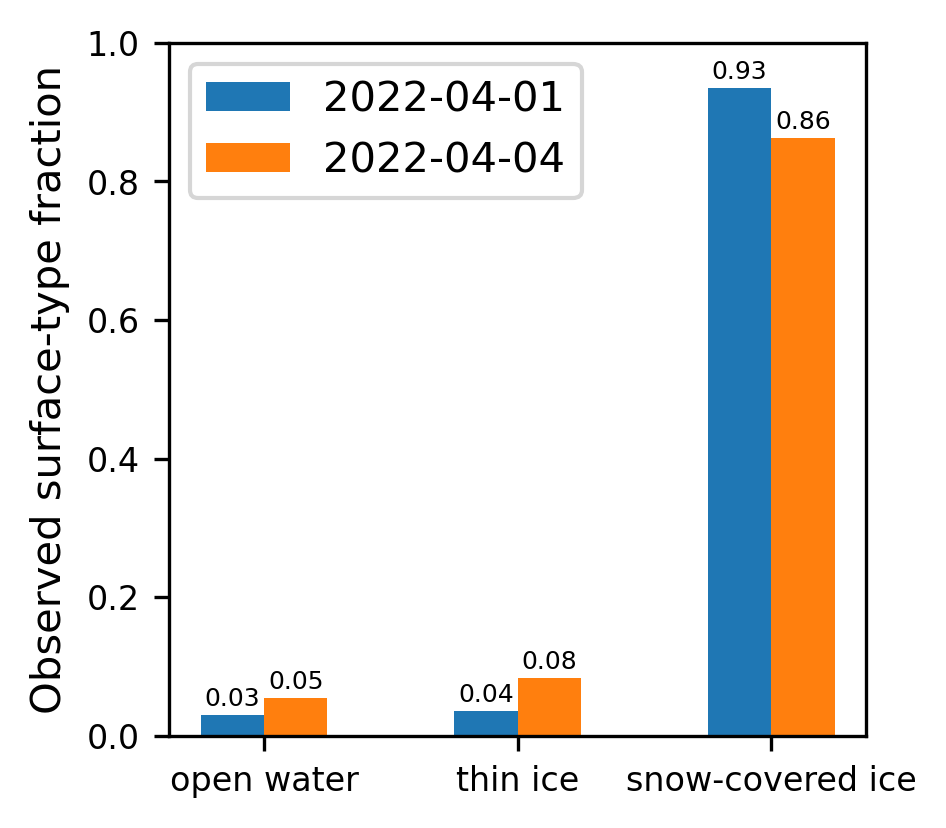

In [82]:
fig, ax = plt.subplots(1, figsize=(3, 3))

rects2 = ax.bar([1, 2, 3], [open_water_strong, thin_ice_strong, snow_covered_ice_strong], label='2022-04-01', width=.25)
rects1 = ax.bar([1.25, 2.25, 3.25], [open_water_weak, thin_ice_weak, snow_covered_ice_weak], label='2022-04-04', width=.25)

ax.bar_label(rects1, padding=1, fmt='%.2f', size=6)
ax.bar_label(rects2, padding=1, fmt='%.2f', size=6)

ax.axes.grid(False)
ax.set_xticks([1.125, 2.125, 3.125])
ax.set_xticklabels(['open water', 'thin ice', 'snow-covered ice'])

ax.set_ylabel('Observed surface-type fraction')
ax.set_ylim(0, 1)




ax.legend()
plt.savefig('../../plots/strong_weak_type_comparison.png', dpi=300, bbox_inches='tight')

<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3494220/987094067.py:59: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('$T_\mathrm{skin}$ [°C]')
/tmp/ipykernel_3494220/987094067.py:66: SyntaxWarning: invalid escape sequence '\m'
  ax.axvline(-1.8, color='red', alpha=0.7, lw=2, ls='--', label='min. OW $T_\mathrm{S}$')
/tmp/ipykernel_3494220/987094067.py:67: SyntaxWarning: invalid escape sequence '\m'
  ax2.axvline(-1.8, color='red', alpha=0.7, lw=2, ls='--', label='min. OW $T_\mathrm{S}$')
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of tim

2022-04-01 OW: -6.8 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2022-04-01 TI: -11.9 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using fu

2022-04-01 SC: -21.8 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.91 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using fu

2022-04-04 OW: -5.5 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using fu

2022-04-04 TI: -11.9 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using fu

2022-04-04 SC: -18.9 °C


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.93 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


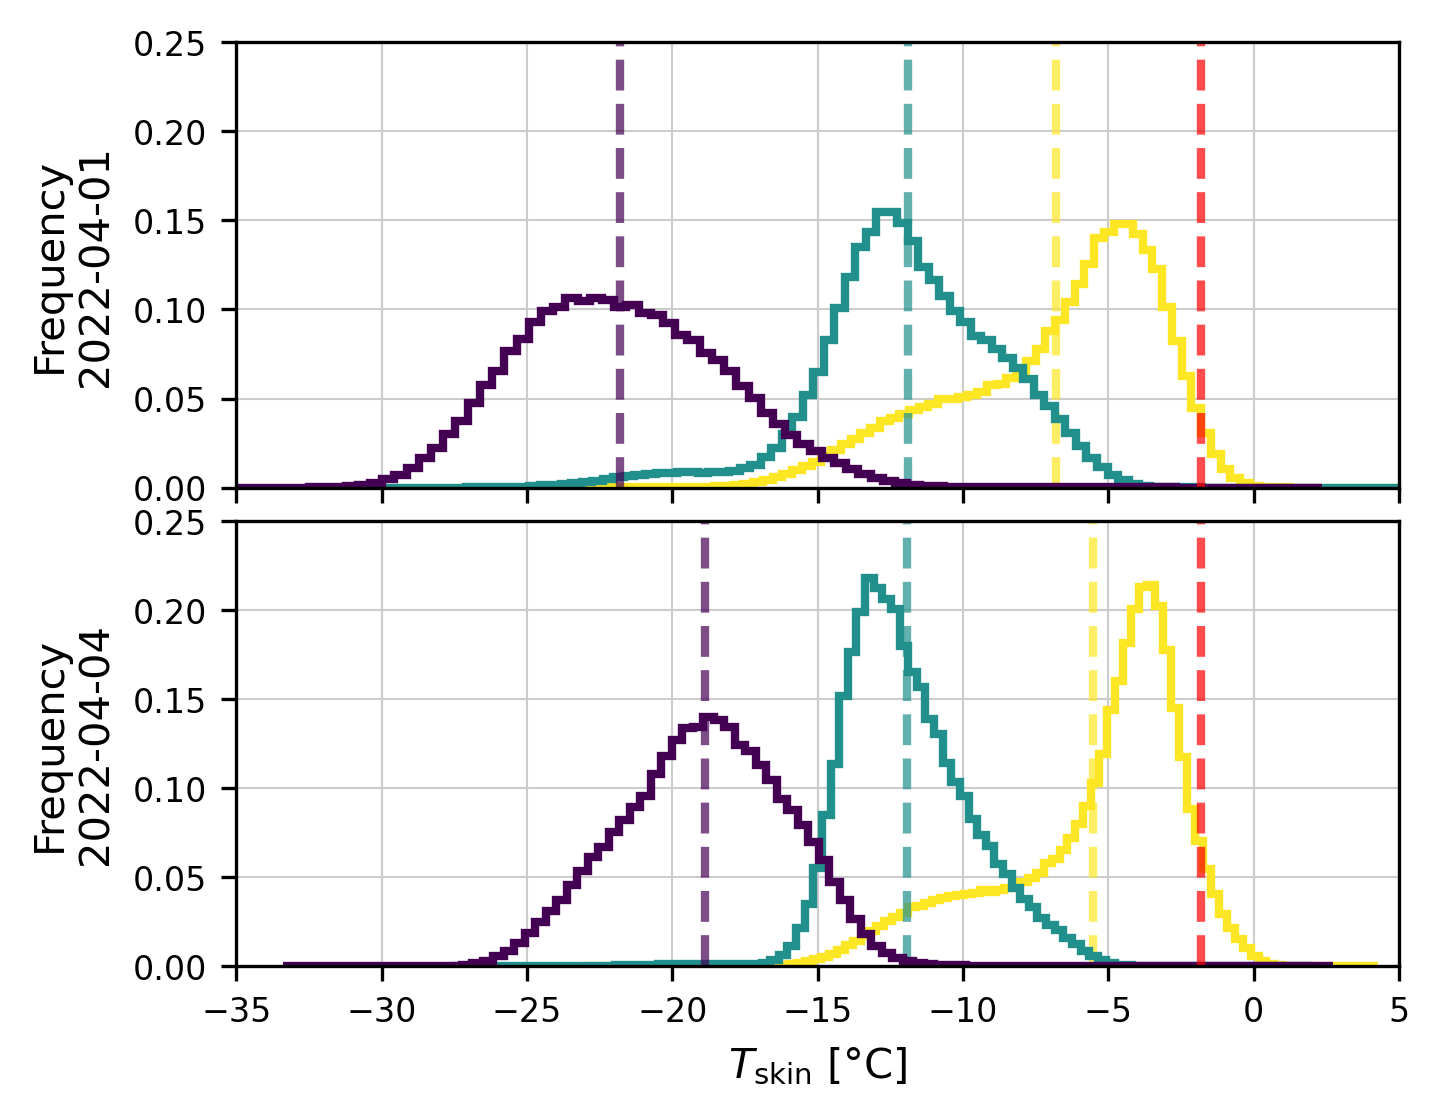

In [257]:
colors = plt.get_cmap('viridis')([.5, 1.5, 2.5, 4.5])
colors2 = plt.get_cmap('viridis')([.75, 1.75, 2.75, 4.75])
colors = plt.get_cmap('viridis_r')([0, .5, 1.5, 2.5, 4.5])

fig, (ax, ax2) = plt.subplots(2, figsize=(5, 4), gridspec_kw={'hspace' : .075}, sharex=True)

ds_strong_matched.load()
ds_weak.load()


IST = ds_strong_matched['T_skin']
label = ds_strong_matched['label']

IST = ds_strong_matched['T_skin']

mask = (label <= 1)
median = IST.where(mask.values).mean()
print(f'2022-04-01 OW: {median.values:.1f} °C')
ax.axvline(median, color=colors[0], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax, color=colors[0], histtype='step', lw=2, bins=100, density=1, label='OW')

mask = (label > 1) &  (label <= 3)
median = IST.where(mask.values).mean()
print(f'2022-04-01 TI: {median.values:.1f} °C')
ax.axvline(median, color=colors[1], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax, color=colors[1], histtype='step', lw=2, bins=100, density=1, label='TI')

mask = (label >= 3)
median = IST.where(mask.values).mean()
print(f'2022-04-01 SC: {median.values:.1f} °C')
ax.axvline(median, color=colors[2], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax, color=colors[2], histtype='step', lw=2, bins=100, density=1, label='SC')


IST = ds_weak['T_skin']
label = ds_weak['label']

mask = (label <= 1)
median = IST.where(mask.values).mean()
print(f'2022-04-04 OW: {median.values:.1f} °C')
ax2.axvline(median, color=colors[0], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax2, color=colors[0], histtype='step', lw=2, bins=100, density=1, label='OW')

mask = (label > 1) &  (label <= 3)
median = IST.where(mask.values).mean()
print(f'2022-04-04 TI: {median.values:.1f} °C')
ax2.axvline(median, color=colors[1], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax2, color=colors[1], histtype='step', lw=2, bins=100, density=1, label='TI')

mask = (label >= 3)
median = IST.where(mask.values).mean()
print(f'2022-04-04 SC: {median.values:.1f} °C')
ax2.axvline(median, color=colors[2], alpha=0.7, lw=2, ls='--', label=f'{median.values:.1f} °C')
IST.where(mask.values).plot.hist(ax=ax2, color=colors[2], histtype='step', lw=2, bins=100, density=1, label='SC')



#ax2.legend()
ax2.set_xlabel('$T_\mathrm{skin}$ [°C]')
ax.set_xlabel('')
#ax2.set_xticklabels([''])
#ax2.set_xlabel('')
#ax2.set_ylabel('Total counts [$10^4$]')
#ax.set_ylabel('Normalized frequency')
#ax2.set_yticklabels(ax2.get_yticks()/1e4)
ax.axvline(-1.8, color='red', alpha=0.7, lw=2, ls='--', label='min. OW $T_\mathrm{S}$')
ax2.axvline(-1.8, color='red', alpha=0.7, lw=2, ls='--', label='min. OW $T_\mathrm{S}$')
ax.set_xlim(-35, 5)
ax.set_ylim(0, 0.25)
ax2.set_ylim(0, 0.25)
  
# for i, a in enumerate([ax2, ax]):
#     a.text(0.05, 1.18, ref[i], transform=a.transAxes, fontsize=12, fontweight='bold', va='top')

ax.set_ylabel('Frequency\n2022-04-01')
ax2.set_ylabel('Frequency\n2022-04-04')

plt.savefig('../../plots/weak_strong_Ts_hist_by_type.png', dpi=300, bbox_inches='tight')


Task exception was never retrieved
future: <Task finished name='Task-39476484' coro=<Client._gather.<locals>.wait() done, defined at /home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

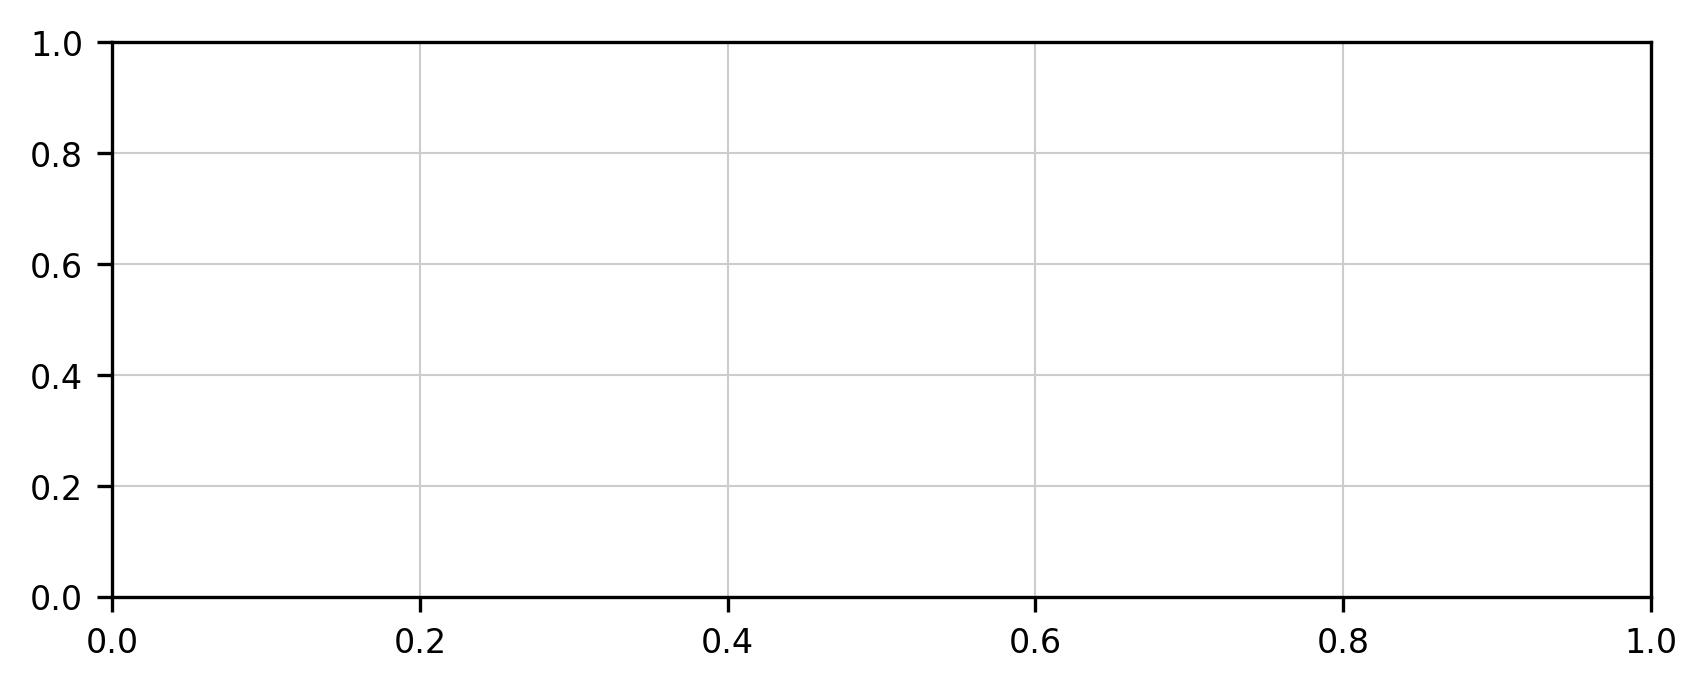

In [258]:
moc_per_time = histogram(pred_2d_all.label, dim=['x', 'y'], bins=bins).argmax(dim='label_bin').persist() 
x = pred_2d_all.lon
y = pred_2d_all.lat

fig, ax = plt.subplots()

ax.scatter(x, y, c=moc_per_time, s=1, alpha=.5)
ax.set_ylim(75, 81)
ax.set_xlim(-10, 12)

In [ ]:
open_water = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 1), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')
thick_ice = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 4), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')
thin_ice = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 2), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')



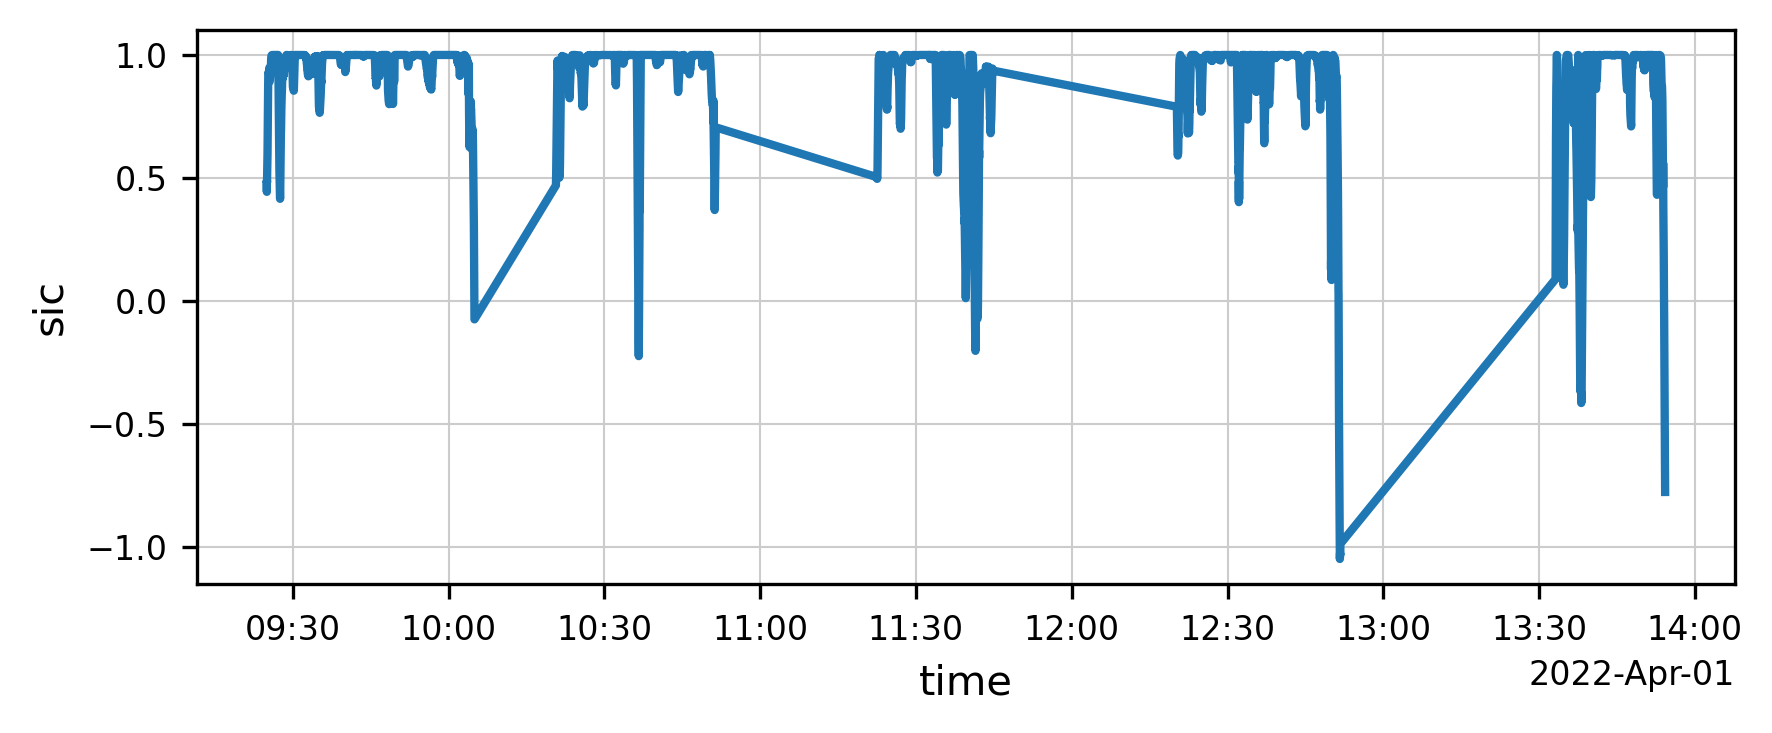

In [ ]:
total = pred_2d_all.label.size

open_water = pred_2d_all.where(pred_2d_all.label == 1, drop=True).label.size / total
nilas = pred_2d_all.where(pred_2d_all.label == 4, drop=True).label.size / total
thin_ice = pred_2d_all.where(pred_2d_all.label == 3, drop=True).label.size / total
thick_ice = pred_2d_all.where(pred_2d_all.label == 2, drop=True).label.size / total


KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

In [ ]:
print(open_water, nilas, thin_ice, thick_ice)

1.0 1.0 1.0 1.0


In [ ]:
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output


@widgets.interact(time=widgets.IntSlider(min=0, max=pred_2d_all.time.size-1, step=1, value=0))
def plot_map(time):
    clear_output(wait=True)

    #fig, ax = plt.gcf(), plt.gcf().get_axes()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    im = pred_2d_all.label.isel(time=time).plot.contourf(ax=ax[1], cmap='viridis', vmin=1, vmax=4, add_colorbar=False, levels=[0, 1, 2, 4])
    im2 = pred_2d_all.T_skin.isel(time=time).plot(ax=ax[0], cmap='plasma', vmin=-30, vmax=0, add_colorbar=False)
    ax[1].set_aspect('equal')
    ax[0].set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax[1], fraction=0.05, pad=0.04)
    cbar.set_ticks([1, 2, 4])
    cbar.set_ticklabels(['Open Water', 'Thin Ice', 'Thick Ice'])
    cbar = fig.colorbar(im2, ax=ax[0], fraction=0.05, pad=0.04)
    cbar.set_label('T_skin [°C]')
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])    
    ax[1].set_title('')	
    fig.canvas.draw_idle()
    plt.show()





interactive(children=(IntSlider(value=0, description='time', max=8722), Output()), _dom_classes=('widget-inter…

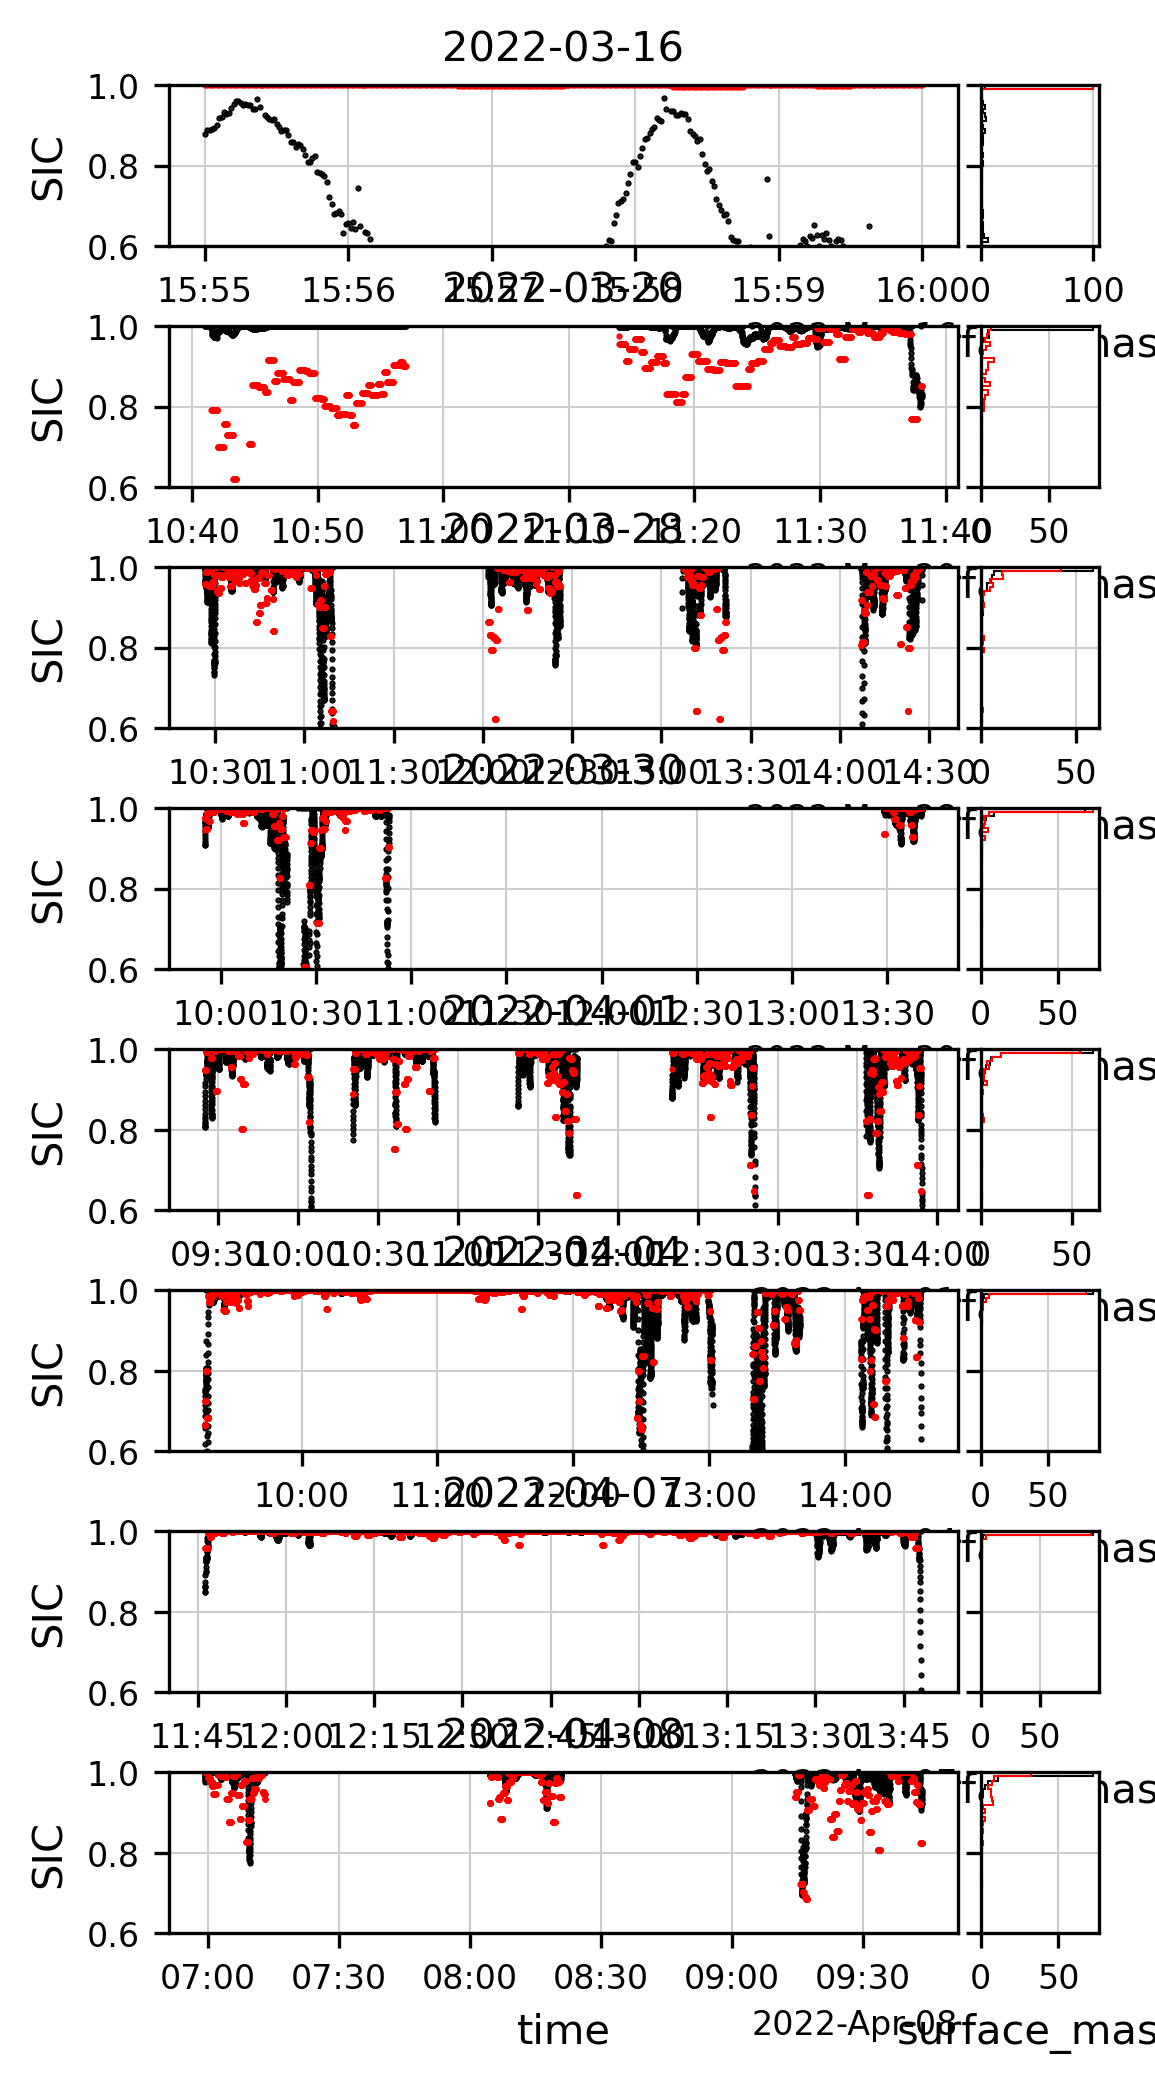

In [ ]:
N, N_time = np.unique(pred_2d_all.time.dt.dayofyear, return_counts=True)

N_days = len(N)


fig, ax = plt.subplots(N_days, 2, figsize=(4, 1 * N_days),
    gridspec_kw={'hspace': 0.5, 'wspace': 0.05, 'width_ratios': [1, 0.15]},
    sharey=True)

for i, day in enumerate(N):
    pred_2d_all['sic'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot(ax=ax[i, 0], marker='o', linestyle='', color='k', label='VELOX', markersize=.5)
    mira_subset['surface_mask'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot(ax=ax[i, 0], marker='o', linestyle='', color='r', label='MIRA', markersize=.5)
    pred_2d_all['sic'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot.hist(ax=ax[i, 1], bins=50, color='k', label='VELOX', range=(0.5, 1), histtype='step',  orientation='horizontal', density=True, lw=.5)
    mira_subset['surface_mask'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot.hist(ax=ax[i, 1], bins=50, color='r', label='MIRA', range=(0.5, 1), histtype='step', orientation='horizontal', density=True, lw=.5)

    date = pd.to_datetime(pred_2d_all.time.isel(time=pred_2d_all.time.dt.dayofyear == day).values[0]).strftime('%Y-%m-%d')	

    ax[i, 0].set_title(date)
    ax[i, 0].set_ylim(0.6, 1)
    ax[i, 0].set_ylabel('SIC')



In [ ]:
x = ds_tb.lon.isel(band=0)
y = ds_tb.lat.isel(band=0)
c = ds_tb.isel(x=slice(317, 327), y=slice(247, 257)).surface_mask.mean(dim=['x', 'y'])

fig, ax = plt.subplots(1, figsize=(5, 4))

ax.scatter(x, y, c=c, cmap='viridis')
ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]')

cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', alpha=0.7)
cbar.set_label('Sea ice type')

ax.set_ylim(76,81)
ax.set_xlim(-12, 12)


AttributeError: 'Dataset' object has no attribute 'surface_mask'

In [ ]:
637 // 2, 507 // 2

(318, 253)

In [ ]:
nadirs = []

for dist in [10, 25, 50, 100, 150, 200, 250]:

    nadir = ds_tb['skin_T'].isel(x=slice(318 - dist, 318 + dist), y=slice(253 - dist, 253 + dist)).mean(dim=['x', 'y'])
    nadirs.append(nadir)


KeyError: "No variable named 'skin_T'. Variables on the dataset include ['BT_2D', 'BT_Center', 'alt', 'lat', 'lon', 'time', 'yaw', 'sur_rgh', 'neighbor_mean', 'neighbor_std']"

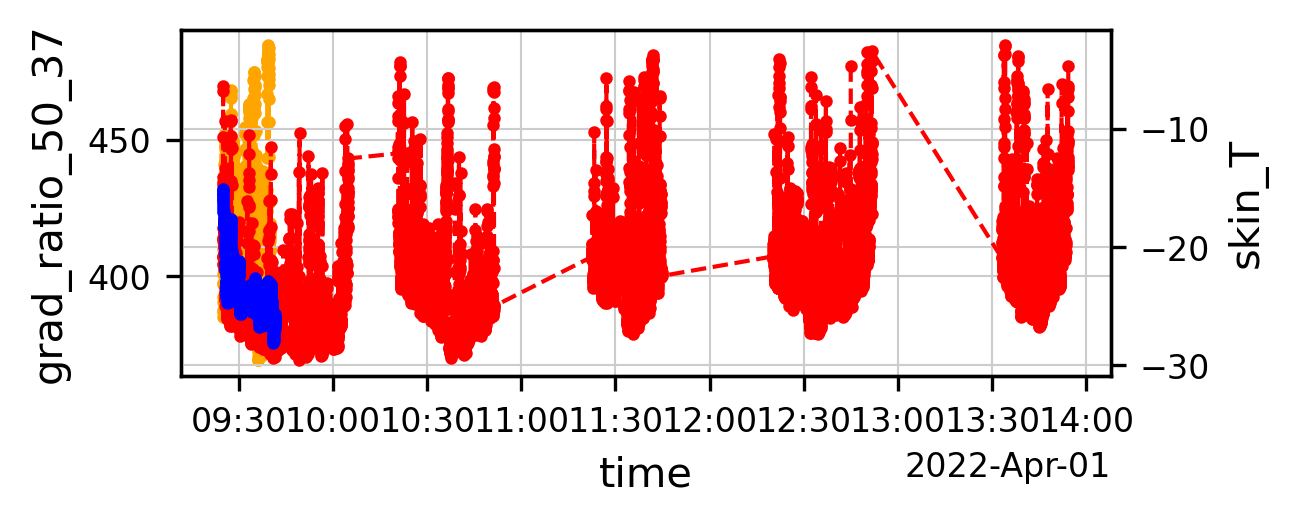

In [ ]:
fig, ax = plt.subplots(figsize=(4, 1.5))

mira_subset.grad_ratio_50_37.isel(time=slice(0, 1000)).plot(color='orange', lw=1, linestyle='--', markersize=2, marker='o')


ax1 = ax.twinx()



# try different central averages for the skin temperature

#for i, nadir in enumerate(nadirs):
#    nadir.plot(ax=ax1, lw=1, linestyle='--', markersize=2, marker='o')

nadirs[0].plot(ax=ax1, lw=1, linestyle='--', markersize=2, marker='o', color='r')


ds_tb['skin_T'].mean(dim=['x', 'y']).isel(time=slice(0, 1000)).plot(ax=ax1, color='b', lw=1, linestyle='--', markersize=2, marker='o')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


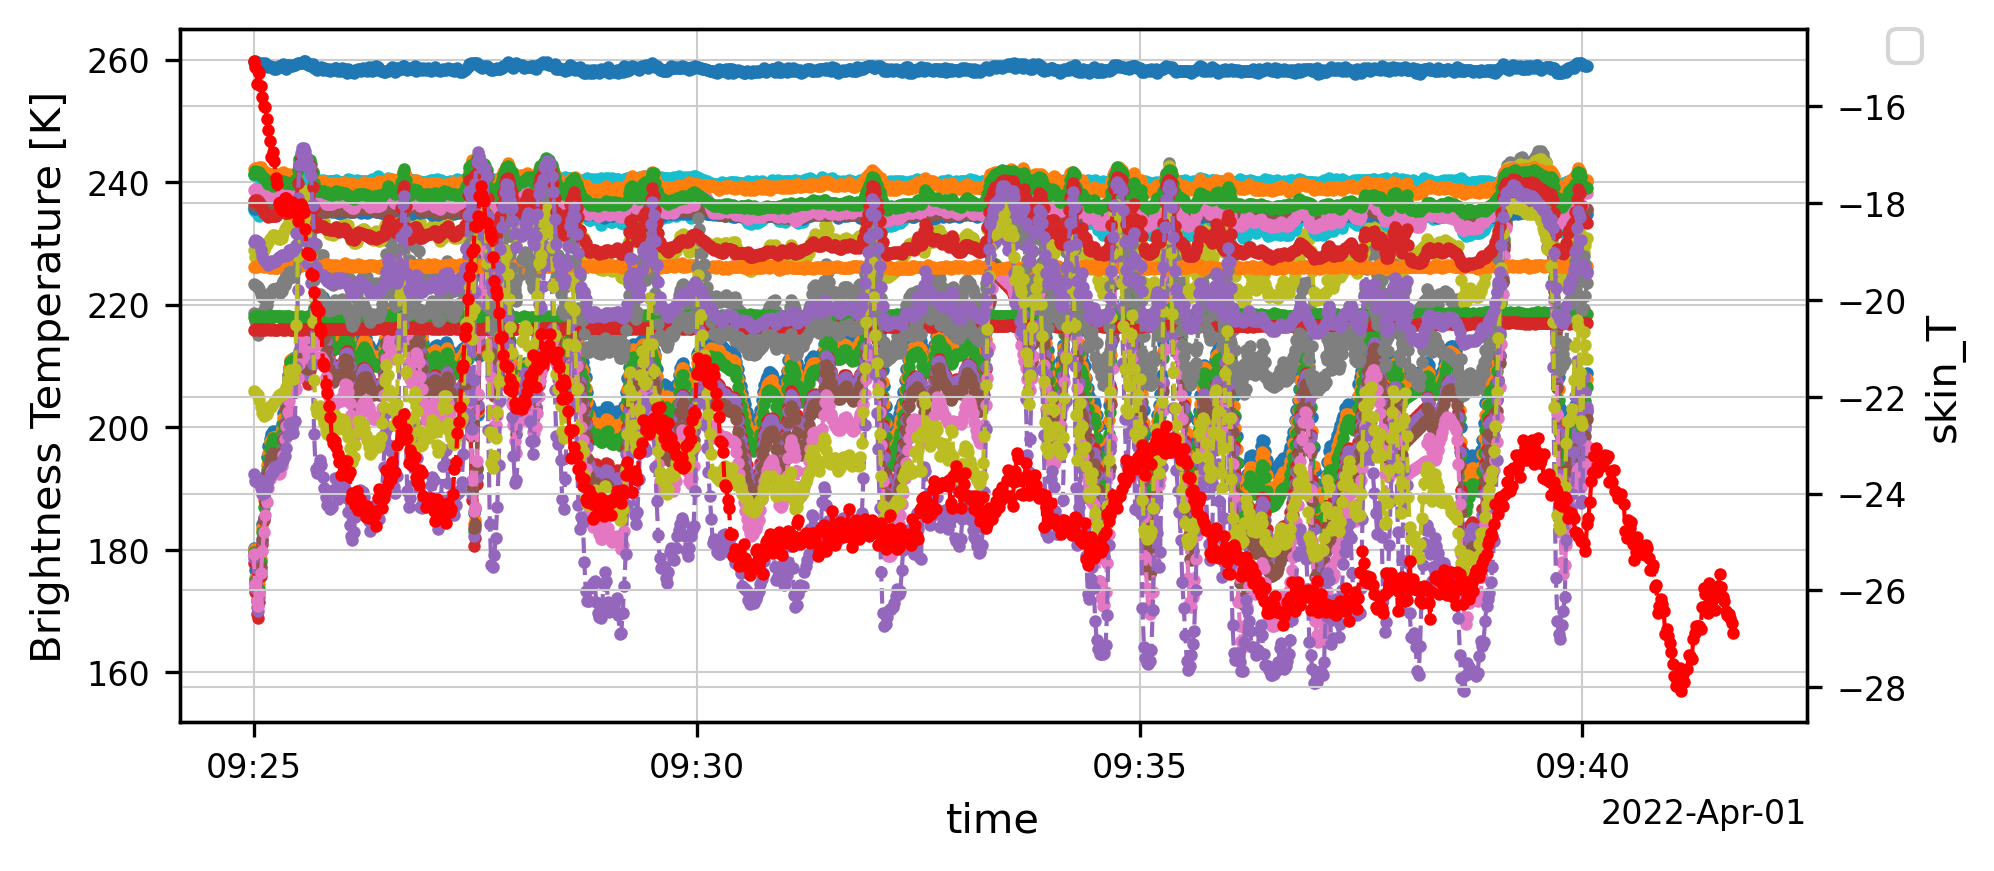

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

mira_subset.TB.isel(time=slice(0, 1000)).plot(hue='uniRadiometer_freq',lw=1, linestyle='--', markersize=2, marker='o')

ax1 = ax.twinx()
ds_tb['skin_T'].mean(dim=['x', 'y']).isel(time=slice(0, 1000)).plot(ax=ax1, color='r', lw=1, linestyle='--', markersize=2, marker='o')


mira_subset

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

7it [00:15,  2.18s/it]


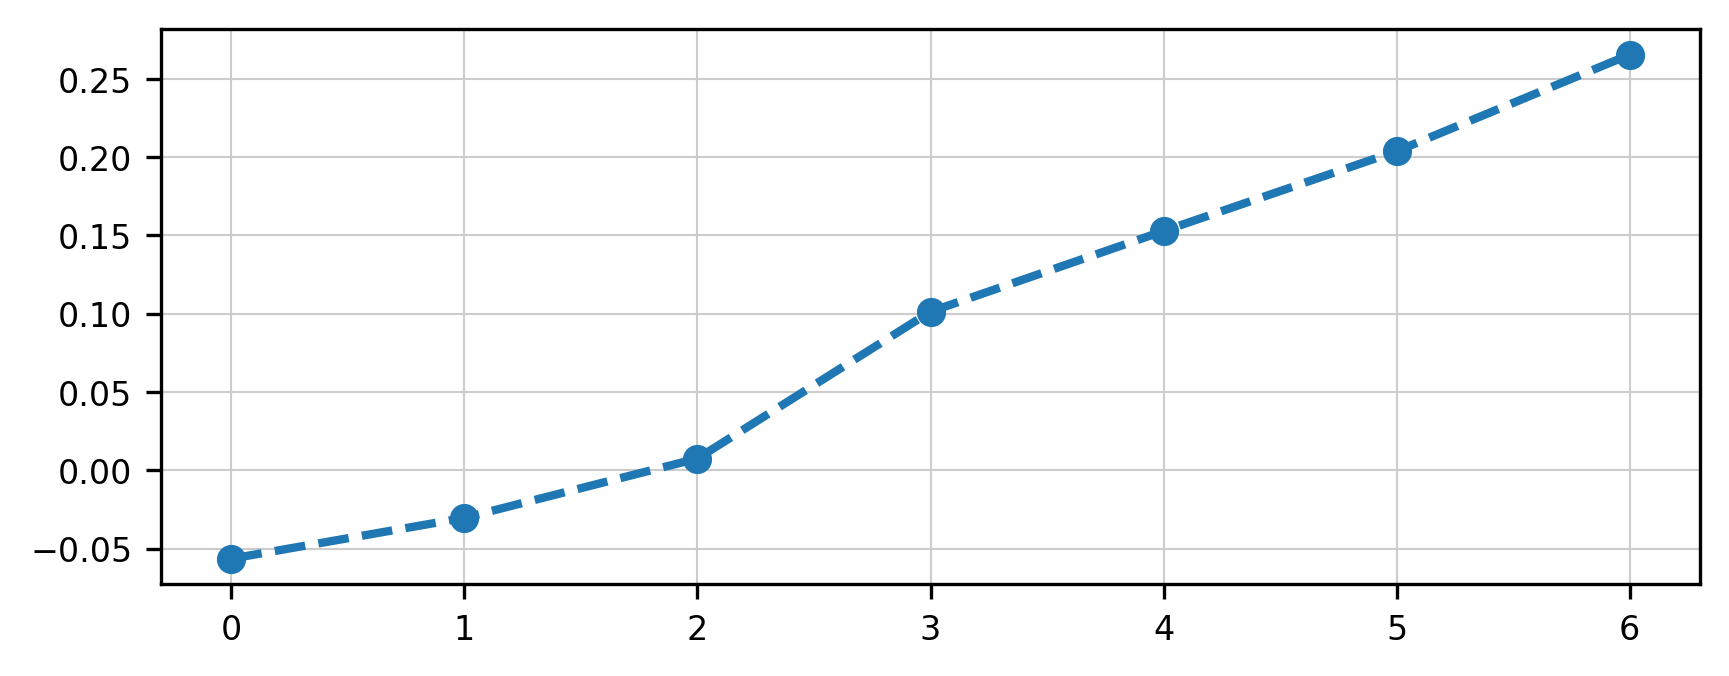

In [ ]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr    

correlations = []

nadir_skin_T = ds_tb['skin_T'].mean(dim=['x', 'y'])

for i, nadir_skin_T in tqdm(enumerate(nadirs)):

    x = mira_subset.TB.isel(uniRadiometer_freq=i).values
    y = nadir_skin_T.values

    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]



    #correlations.append(r2_score(x, y))
    correlations.append(pearsonr(x, y)[0])	

plt.plot(correlations, marker='o', linestyle='--')




In [ ]:
correlation_matrix.values

array([[-0.05641092, -0.0544872 , -0.04519255, -0.01230652,  0.0190807 ,
         0.03892535,  0.04624107],
       [-0.03314771, -0.03034125, -0.01987258,  0.01385262,  0.0444761 ,
         0.06305716,  0.06926495],
       [-0.00745296, -0.00383615,  0.00754231,  0.04100135,  0.06989404,
         0.08647712,  0.09106464],
       [ 0.05041038,  0.05585043,  0.06880612,  0.10137624,  0.1272627 ,
         0.14046676,  0.14221129],
       [ 0.07665594,  0.08287803,  0.09641378,  0.12836218,  0.1528689 ,
         0.16459487,  0.16511565],
       [ 0.12038116,  0.12781702,  0.14224865,  0.17296073,  0.19485392,
         0.20385384,  0.20214288],
       [ 0.19593242,  0.20551729,  0.22140868,  0.24953488,  0.26676051,
         0.27102098,  0.26553307],
       [ 0.37398097,  0.38818582,  0.4051752 ,  0.42423223,  0.42950659,
         0.42299373,  0.40929729],
       [ 0.39742662,  0.41234032,  0.43023646,  0.45067376,  0.45713907,
         0.45148458,  0.43833618],
       [ 0.48944987,  0.5076

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


7 25


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Averaging distance from nadir [m]')

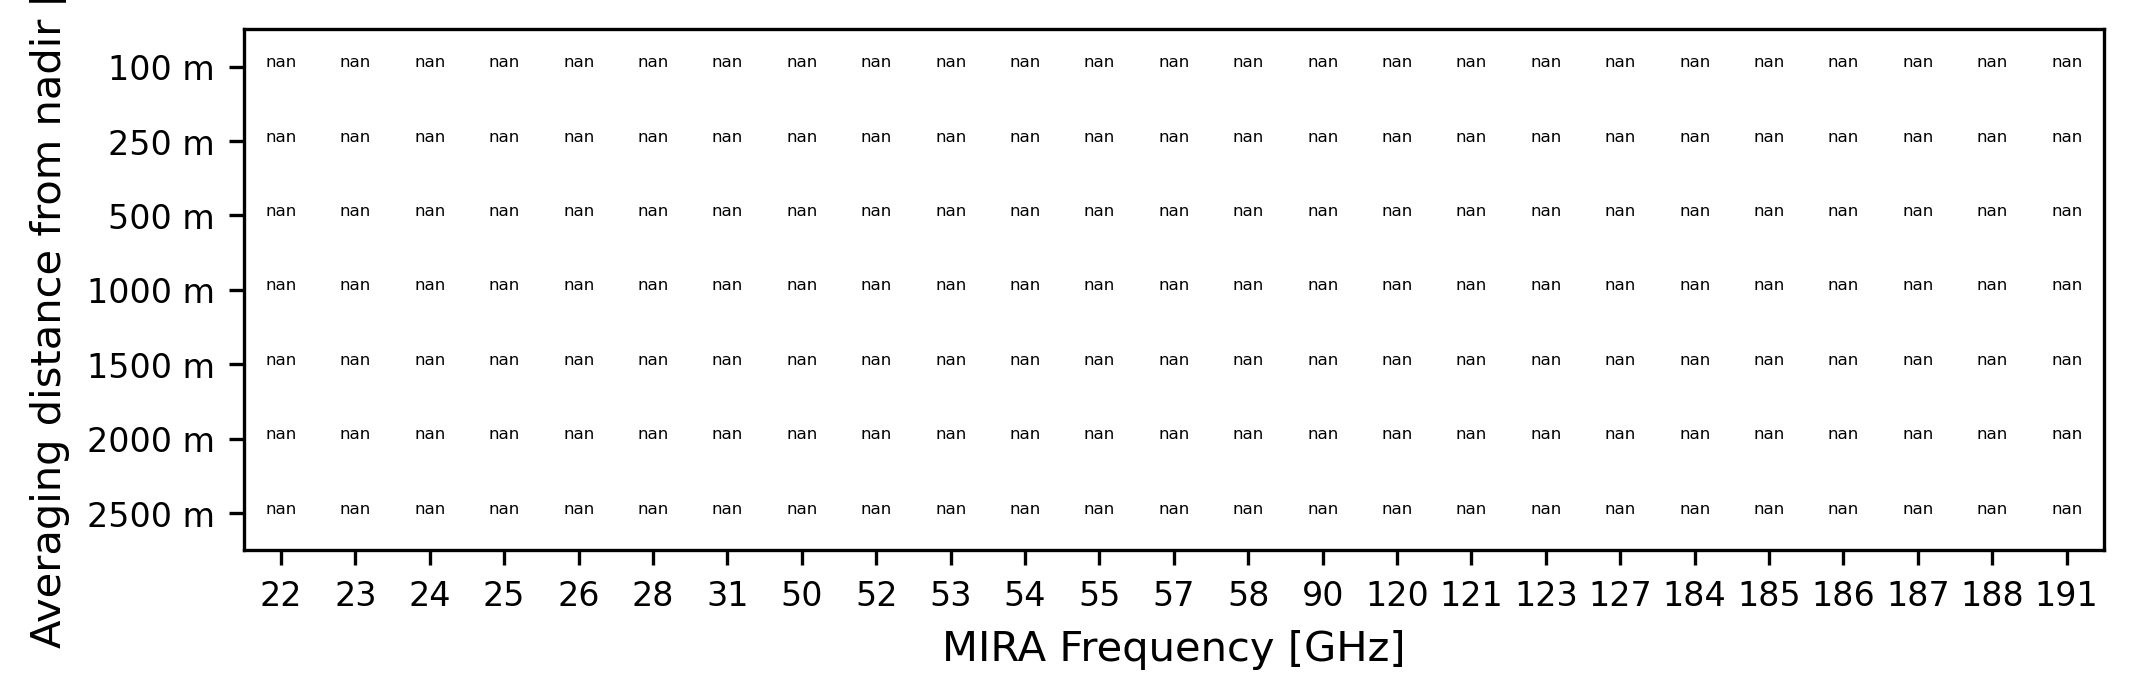

In [ ]:
#xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time')

### plot the numbers into the heatmap 

fig, ax = plt.subplots(figsize=(8, 4))


#tb_thermal_bands = ds_tb['BT_2D'].isel(x=slice(318 - 250, 318 + 250), y=slice(253 - 250, 253 + 250)).mean(dim=['x', 'y'])

correlation_matrix = xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time').persist()

data = correlation_matrix.values.T

im = ax.imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)

# We want to show all ticks...
y_shape, x_shape = data.shape

print(y_shape, x_shape)

ax.set_xticks(np.arange(x_shape))
ax.set_yticks(np.arange(y_shape))

# ... and label them with the respective list entries

ax.set_yticklabels([f'{dist*10} m' for dist in [10, 25, 50, 100, 150, 200, 250]])
ax.set_xticklabels([f'{freq:.0f}' for freq in mira_subset.uniRadiometer_freq.values])

# Add the text
ax.axes.grid(False)

for i in range(y_shape):
    for j in range(x_shape):
        text = ax.text(j, i, f'{data[i, j]:.2f}',
                       ha="center", color="k", fontsize=4) 

ax.set_xlabel('MIRA Frequency [GHz]')

ax.set_ylabel('Averaging distance from nadir [m]')




KeyboardInterrupt: 

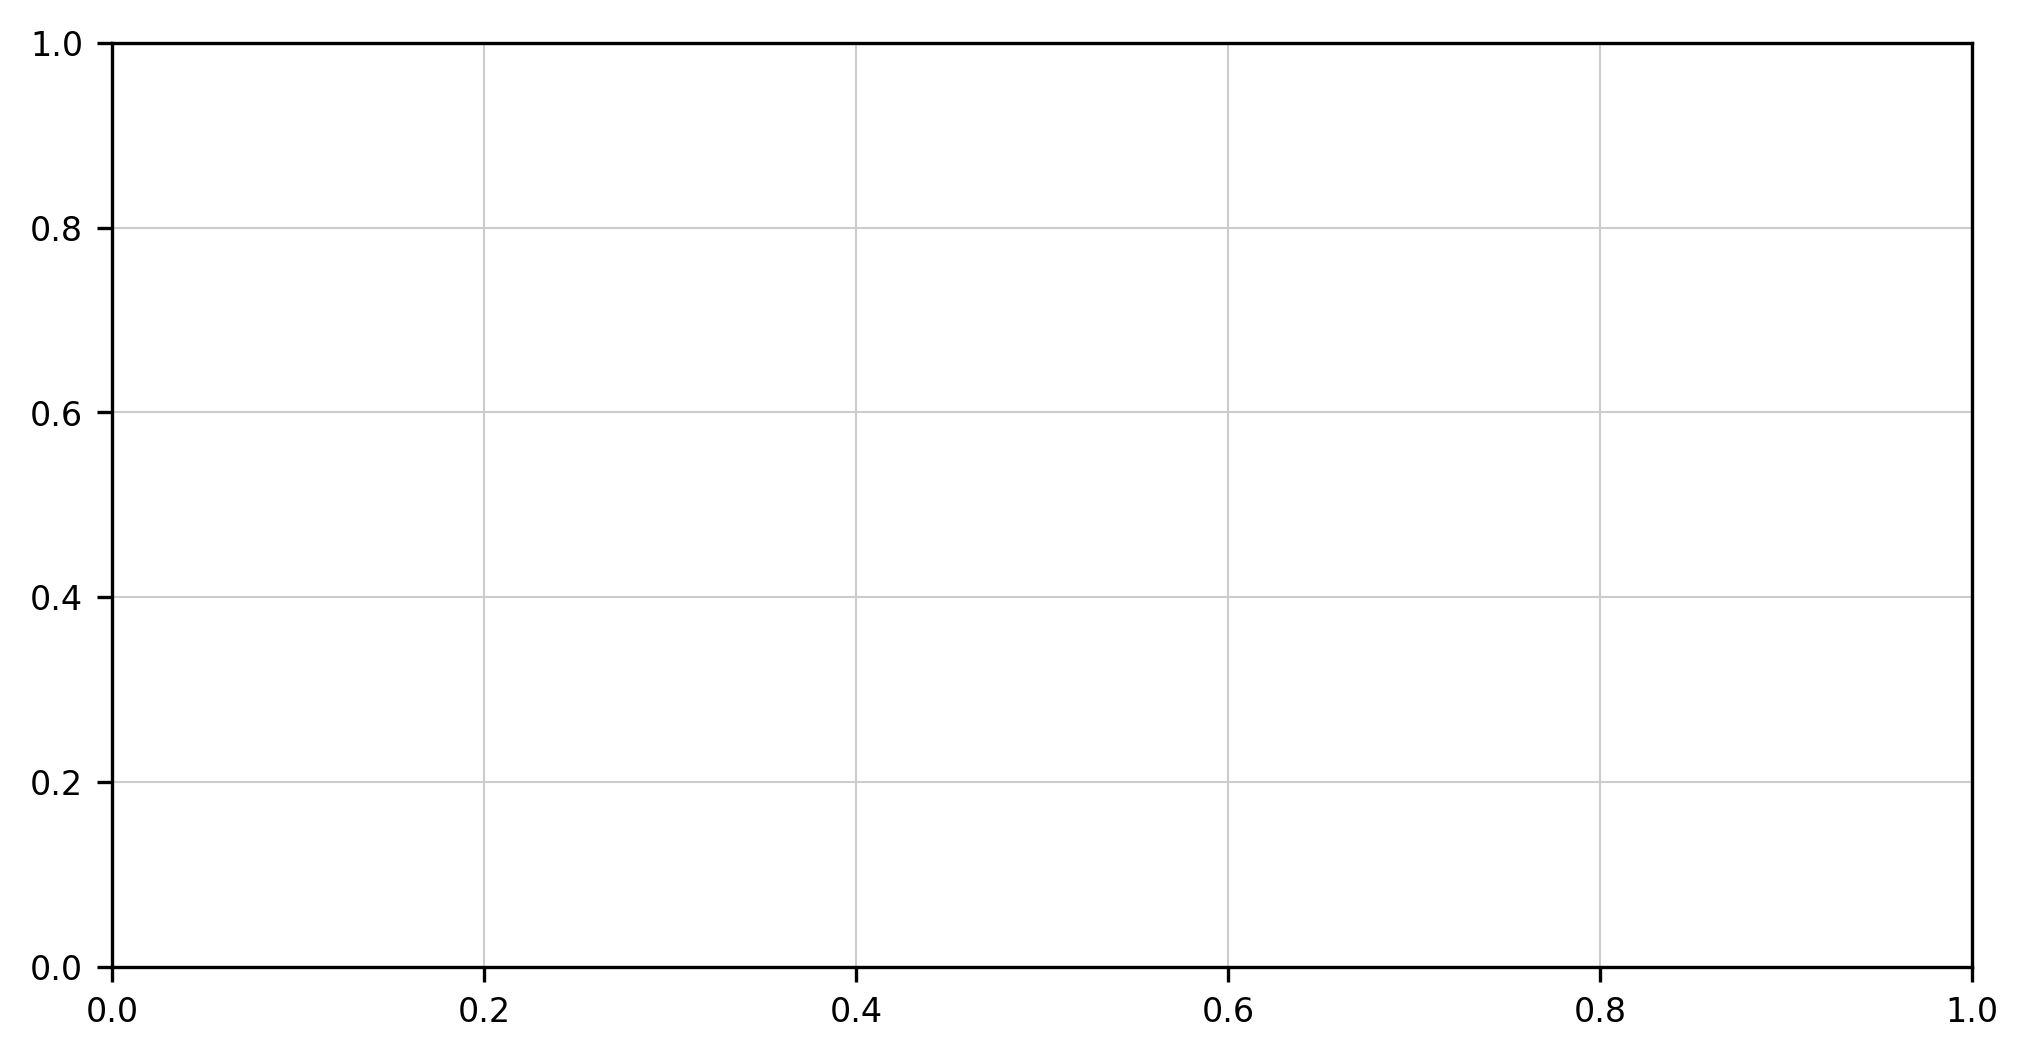

In [ ]:
#xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time')

### plot the numbers into the heatmap 

fig, ax = plt.subplots(figsize=(8, 4))


tb_thermal_bands = ds_tb['BT_2D'].isel(x=slice(318 - 250, 318 + 250), y=slice(253 - 250, 253 + 250)).mean(dim=['x', 'y'])

correlation_matrix = xr.corr(mira_subset.TB, tb_thermal_bands, dim='time').persist()

data = correlation_matrix.values.T

im = ax.imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)

# We want to show all ticks...
y_shape, x_shape = data.shape

print(y_shape, x_shape)

ax.set_xticks(np.arange(x_shape))
ax.set_yticks(np.arange(y_shape))

# ... and label them with the respective list entries

ax.set_yticklabels([f'{band}' for band in [1, 2, 3, 5, 6]])
ax.set_xticklabels([f'{freq:.0f}' for freq in mira_subset.uniRadiometer_freq.values])

# Add the text
ax.axes.grid(False)

for i in range(y_shape):
    for j in range(x_shape):
        text = ax.text(j, i, f'{data[i, j]:.2f}',
                       ha="center", color="k", fontsize=4) 

ax.set_xlabel('MIRA Frequency [GHz]')

ax.set_ylabel('VELOX Band')




0it [00:00, ?it/s]

25it [01:14,  2.99s/it]


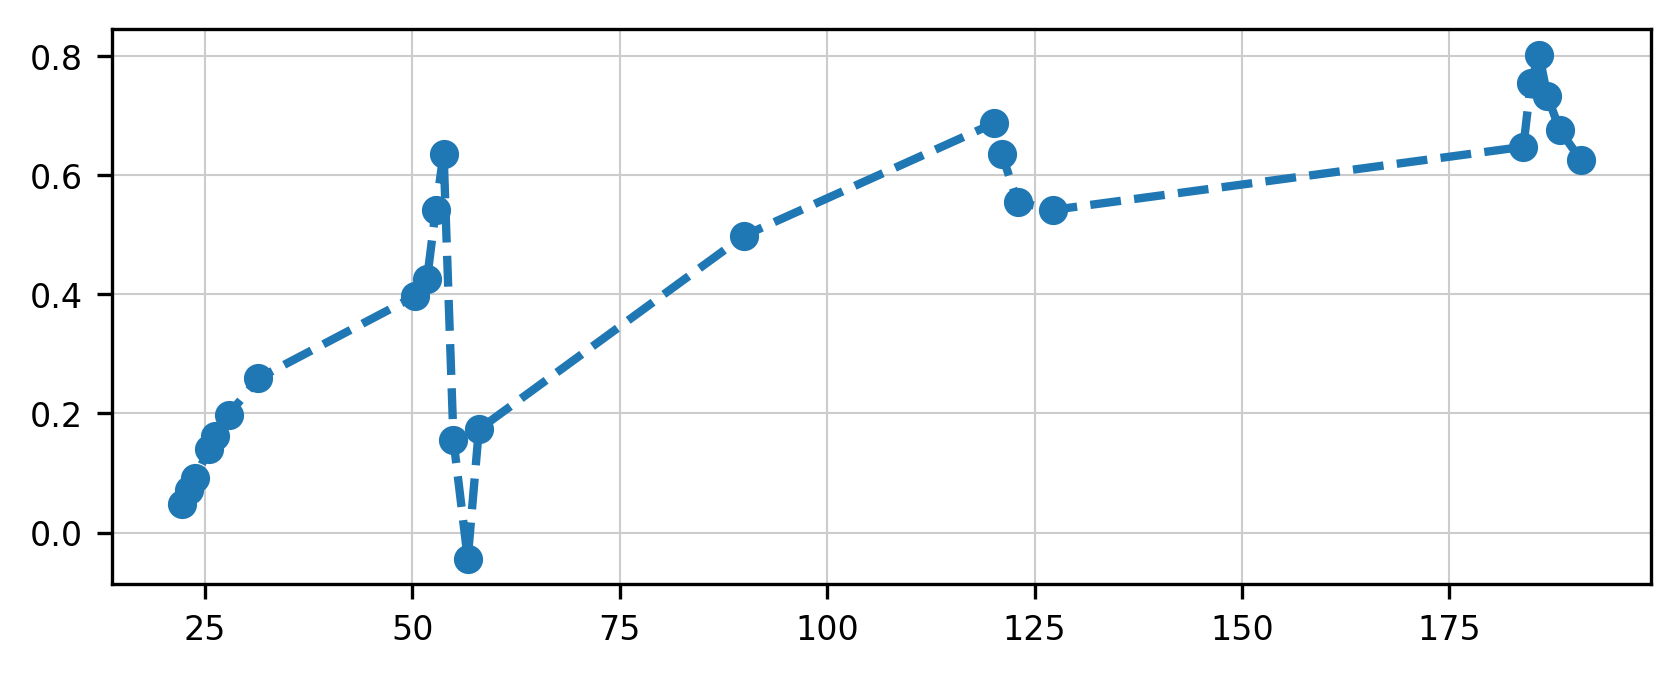

In [ ]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr    

correlations = []

nadir_skin_T = ds_tb['skin_T'].mean(dim=['x', 'y']),



for i, freq in tqdm(enumerate([nadirs])):

    x = mira_subset.TB.sel(uniRadiometer_freq=175, method='nearest').values
    y = nadir_skin_T.values

    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]



    #correlations.append(r2_score(x, y))
    correlations.append(pearsonr(x, y)[0])	

plt.plot(mira_subset.uniRadiometer_freq, correlations, marker='o', linestyle='--')




In [ ]:
correlations

[0.048431041883040996,
 0.07076789208938969,
 0.09148278755336307,
 0.14048774168096223,
 0.16256127641109974,
 0.19798053770753188,
 0.25877621529133055,
 0.3970286818206681,
 0.4260862759378518,
 0.541451249189859,
 0.6363253622725711,
 0.1549745568099256,
 -0.043762779016679736,
 0.17320950319249098,
 0.49867286076433903,
 0.6875338687313343,
 0.6351412701573546,
 0.5552484485202378,
 0.5418164729367725,
 0.6477173989097895,
 0.7555555892934748,
 0.8024457609578982,
 0.7326046399484021,
 0.6757405454350688,
 0.6262289522624391]

In [ ]:
correlations

[-304.6947492303084,
 -275.06366949766783,
 -253.12794527607673,
 -216.7402613050434,
 -206.5333094012281,
 -190.4798794209288,
 -155.99296093888205,
 -619.4209518550057,
 -1866.8450838238562,
 -10637.858948783376,
 -155945.26349059833,
 -261895.64726881406,
 -335460.1487716972,
 -286388.3659842223,
 -90.5065981890808,
 -62743.315242458135,
 -6517.149805822337,
 -506.7674559243774,
 -150.6484407019732,
 -73333.47845612047,
 -88919.92731945017,
 -16949.88881623396,
 -7872.044515274264,
 -2020.7462897012977,
 -631.6124282294761]

In [ ]:
correlation_coefficients

[nan, nan, nan, nan, nan, nan, nan]

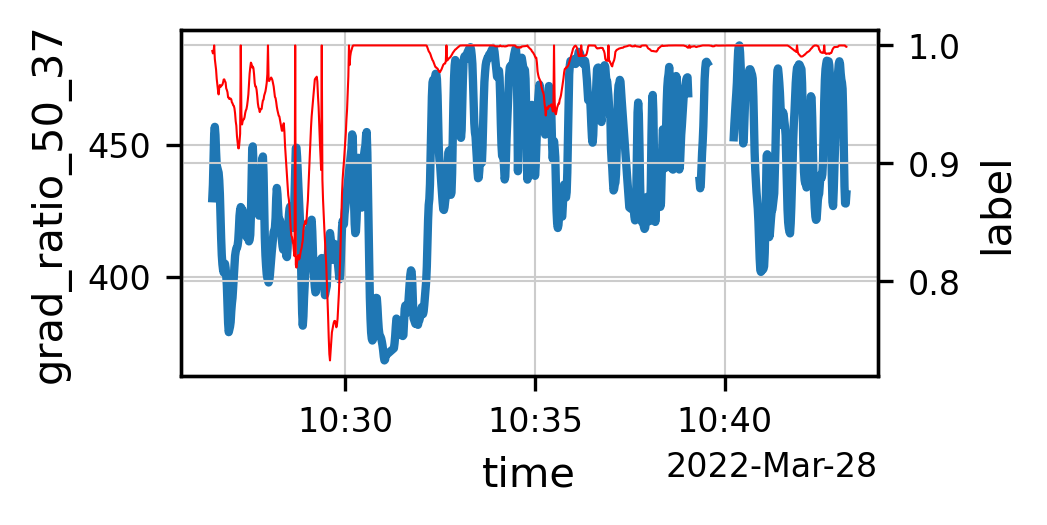

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1.5))

mira_subset.grad_ratio_50_37.isel(time=slice(0, 1000)).plot()

ax1 = ax.twinx()
ds.label.isel(time=slice(0, 1000)).mean(dim=['x', 'y']).plot(ax=ax1, color='red', lw=0.5)